# Last Away

In [1]:
import matplotlib
# matplotlib.use("Qt5Agg") 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import re
import os as os
import mne
import IPython
import seaborn as sns
import scipy
import joblib
import pickle
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest

## import custom functions
import sys
sys.path.append('/home/brooke/pacman/preprocessing/scripts')
import preproc_functions as pf
import average_tfr_functions as avg_tfr

## load rois
%run ../../preprocessing/scripts/roi.py


In [2]:
# folders
raw_dir = '/home/brooke/pacman/raw_data'
preproc_dir = '/home/brooke/pacman/preprocessing'
tfr_dir = '/home/brooke/pacman/preprocessing'


In [36]:
# subjects
new_sub_list = ['BJH017', 'BJH046', 'BJH050', 'BJH051'] 
old_sub_list = ['BJH021', 'BJH025', 'BJH016', 'SLCH002', 'BJH026', 'BJH039', 'LL10', 'LL12', 'LL13', 'LL17', 'LL19']


roi = 'cing'

In [37]:
# save progress cuz it is so long to load these dang things       
with open(f'../ieeg/last_away_average_{roi}.pkl', 'rb') as f:
    tfrs = pickle.load(f)   

sub_list =  old_sub_list
for subject in new_sub_list:
    
    tfr_cases = []         
    # load data
    ghost_TFR = mne.time_frequency.read_tfrs(f"{tfr_dir}/{subject}/ieeg/last_away/ghost-{roi}-tfr.h5")  
    noghost_TFR = mne.time_frequency.read_tfrs(f"{tfr_dir}/{subject}/ieeg/last_away/noghost-{roi}-tfr.h5") 


    # append
    tfr_cases.append(ghost_TFR.data.mean(axis = 0))
    tfr_cases.append(noghost_TFR.data.mean(axis = 0))

    # get mean and append
    tfrs = [tfr_cases] + tfrs
    sub_list = [subject] + sub_list
# invert list so the outer list is the string filter
tfrs_cases = [[tfrs[j][i] for j in range(len(tfrs))] for i in range(len(tfrs[0]))]

# all_subs_averages = []
# for tfr_case in tfrs_cases:

#     tfr_case = tfr_case[6:12]
#     

#     # get indicies of high/low samp rate subs
#     first_ll_sub = [subject for subject in sub_list if "LL" in subject][0]
#     ll_begin = sub_list.index(first_ll_sub)

#     # high sampling rate
#     washu_tfrs = np.asarray(tfr_case[0:ll_begin])
#     washu_tfrs_mean = washu_tfrs.mean(axis = 0)

#     # Low sampling rate
#     ll_tfrs = np.asarray(tfr_case[ll_begin:])
#     ll_tfrs_mean = ll_tfrs.mean(axis = 0)

#     # combine
#     all_subs_tfrs = np.stack((washu_tfrs_mean[:, ::2], ll_tfrs_mean[:, 0:2001]))

#     # mean
#     all_subs_average = all_subs_tfrs.mean(axis = 0)
#     all_subs_averages.append(all_subs_average)


Reading /home/brooke/pacman/preprocessing/BJH017/ieeg/last_away/ghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH017/ieeg/last_away/noghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/ghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/noghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/ghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/noghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/ghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/noghost-cing-tfr.h5 ...


In [38]:
sub_list[6:12]

['BJH016', 'SLCH002', 'BJH026', 'BJH039', 'LL10', 'LL12']

In [45]:
def calculate_last_away_new_sub_average(new_sub_list, old_sub_list, roi, ROIs = None, subregion = None):
    """
    Calculates the average TFRs for the LAST AWAY condition across subjects,
    handling potential differences in sampling rates and saving progress for
    efficiency.

    Args:
        sub_list (list): A list of subject IDs to process.
        string_filters (list): A list of strings to filter TFR cases by.
        roi (str): The name of the region of interest.

    Returns:
        list: A list of lists containing average TFRs for each string filter.

    Steps:
        1. Iterates through subjects:
            - Loads ghost, no ghost average tfr
            - Calculates mean TFRs for each case and appends to a list.
            - Handles exceptions and reports any errors.
        2. Saves intermediate progress to a pickle file.
        3. Invert list structure for easier processing.
        4. Calculates average TFRs for each string filter:
            - Identifies subjects with high or low sampling rates.
            - Calculates separate means for high and low rate TFRs.
            - Combines and averages TFRs from different sampling rates if applicable.
        5. Returns a list of average TFRs for each string filter.
    """
    if subregion is not None:
        # save progress cuz it is so long to load these dang things       
        with open(f'../ieeg/last_away_average_{subregion}.pkl', 'rb') as f:
            tfrs = pickle.load(f)        
    else:
        # save progress cuz it is so long to load these dang things       
        with open(f'../ieeg/last_away_average_{roi}.pkl', 'rb') as f:
            tfrs = pickle.load(f)   

    sub_list =  old_sub_list
    for subject in new_sub_list:
        
        tfr_cases = []         
        # load data
        ghost_TFR = mne.time_frequency.read_tfrs(f"{tfr_dir}/{subject}/ieeg/last_away/ghost-{roi}-tfr.h5")  
        noghost_TFR = mne.time_frequency.read_tfrs(f"{tfr_dir}/{subject}/ieeg/last_away/noghost-{roi}-tfr.h5") 

        # check if subregion is not null
        if subregion is not None:
            
                sub_ROIs = ROIs.copy()[subject]
                        
                subroi_list, subroi_names, subroi_indices = avg_tfr.get_roi_elec_lists(sub_ROIs, ghost_TFR, subregion)
                        
                # create a new tfr with only the mfg channels
                ghost_TFR = ghost_TFR.pick_channels(subroi_list)
                noghost_TFR = noghost_TFR.pick_channels(subroi_list)

        # append
        tfr_cases.append(ghost_TFR.data.mean(axis = 0))
        tfr_cases.append(noghost_TFR.data.mean(axis = 0))

        # get mean and append
        tfrs = [tfr_cases] + tfrs
        sub_list = [subject] + sub_list
    # invert list so the outer list is the string filter
    tfrs_cases = [[tfrs[j][i] for j in range(len(tfrs))] for i in range(len(tfrs[0]))]

    all_subs_averages = []
    for tfr_case in tfrs_cases:

        if any("LL" in subject for subject in sub_list):

            # get indicies of high/low samp rate subs
            first_ll_sub = [subject for subject in sub_list if "LL" in subject][0]
            ll_begin = sub_list.index(first_ll_sub)

            # high sampling rate
            washu_tfrs = np.asarray(tfr_case[0:ll_begin])
            washu_tfrs_mean = washu_tfrs.mean(axis = 0)

            # Low sampling rate
            ll_tfrs = np.asarray(tfr_case[ll_begin:])
            ll_tfrs_mean = ll_tfrs.mean(axis = 0)

            # combine
            all_subs_tfrs = np.stack((washu_tfrs_mean[:, ::2], ll_tfrs_mean[:, 0:2001]))
        
            # mean
            all_subs_average = all_subs_tfrs.mean(axis = 0)
            all_subs_averages.append(all_subs_average)
            
        else:
            
            # high sampling rate
            washu_tfrs = np.asarray(tfr_case)
            washu_tfrs_mean = washu_tfrs.mean(axis = 0)

            # mean
            all_subs_average = washu_tfrs_mean
            all_subs_averages.append(all_subs_average)    

    return all_subs_averages

## OFC

In [4]:
# subjects
new_sub_list = ['BJH017', 'BJH046', 'BJH050', 'SLCH018', 'BJH051']
old_sub_list =  ['BJH021', 'BJH025', 'BJH016', 'SLCH002', 'BJH026', 'BJH027', 'BJH029', 'BJH039', 'BJH041', 'LL10', 'LL12', 'LL13', 'LL14', 'LL17', 'LL19']

all_subs_average_ofcs = calculate_last_away_new_sub_average(new_sub_list, old_sub_list, 'ofc')

# separate averages #
all_subs_average_ofc_conflict = all_subs_average_ofcs[0]
all_subs_average_ofc_noconflict = all_subs_average_ofcs[1]


Reading /home/brooke/pacman/preprocessing/BJH017/ieeg/last_away/ghost-ofc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH017/ieeg/last_away/noghost-ofc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/ghost-ofc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/noghost-ofc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/ghost-ofc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/noghost-ofc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/SLCH018/ieeg/last_away/ghost-ofc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/SLCH018/ieeg/last_away/noghost-ofc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/ghost-ofc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/noghost-ofc-tfr.h5 ...


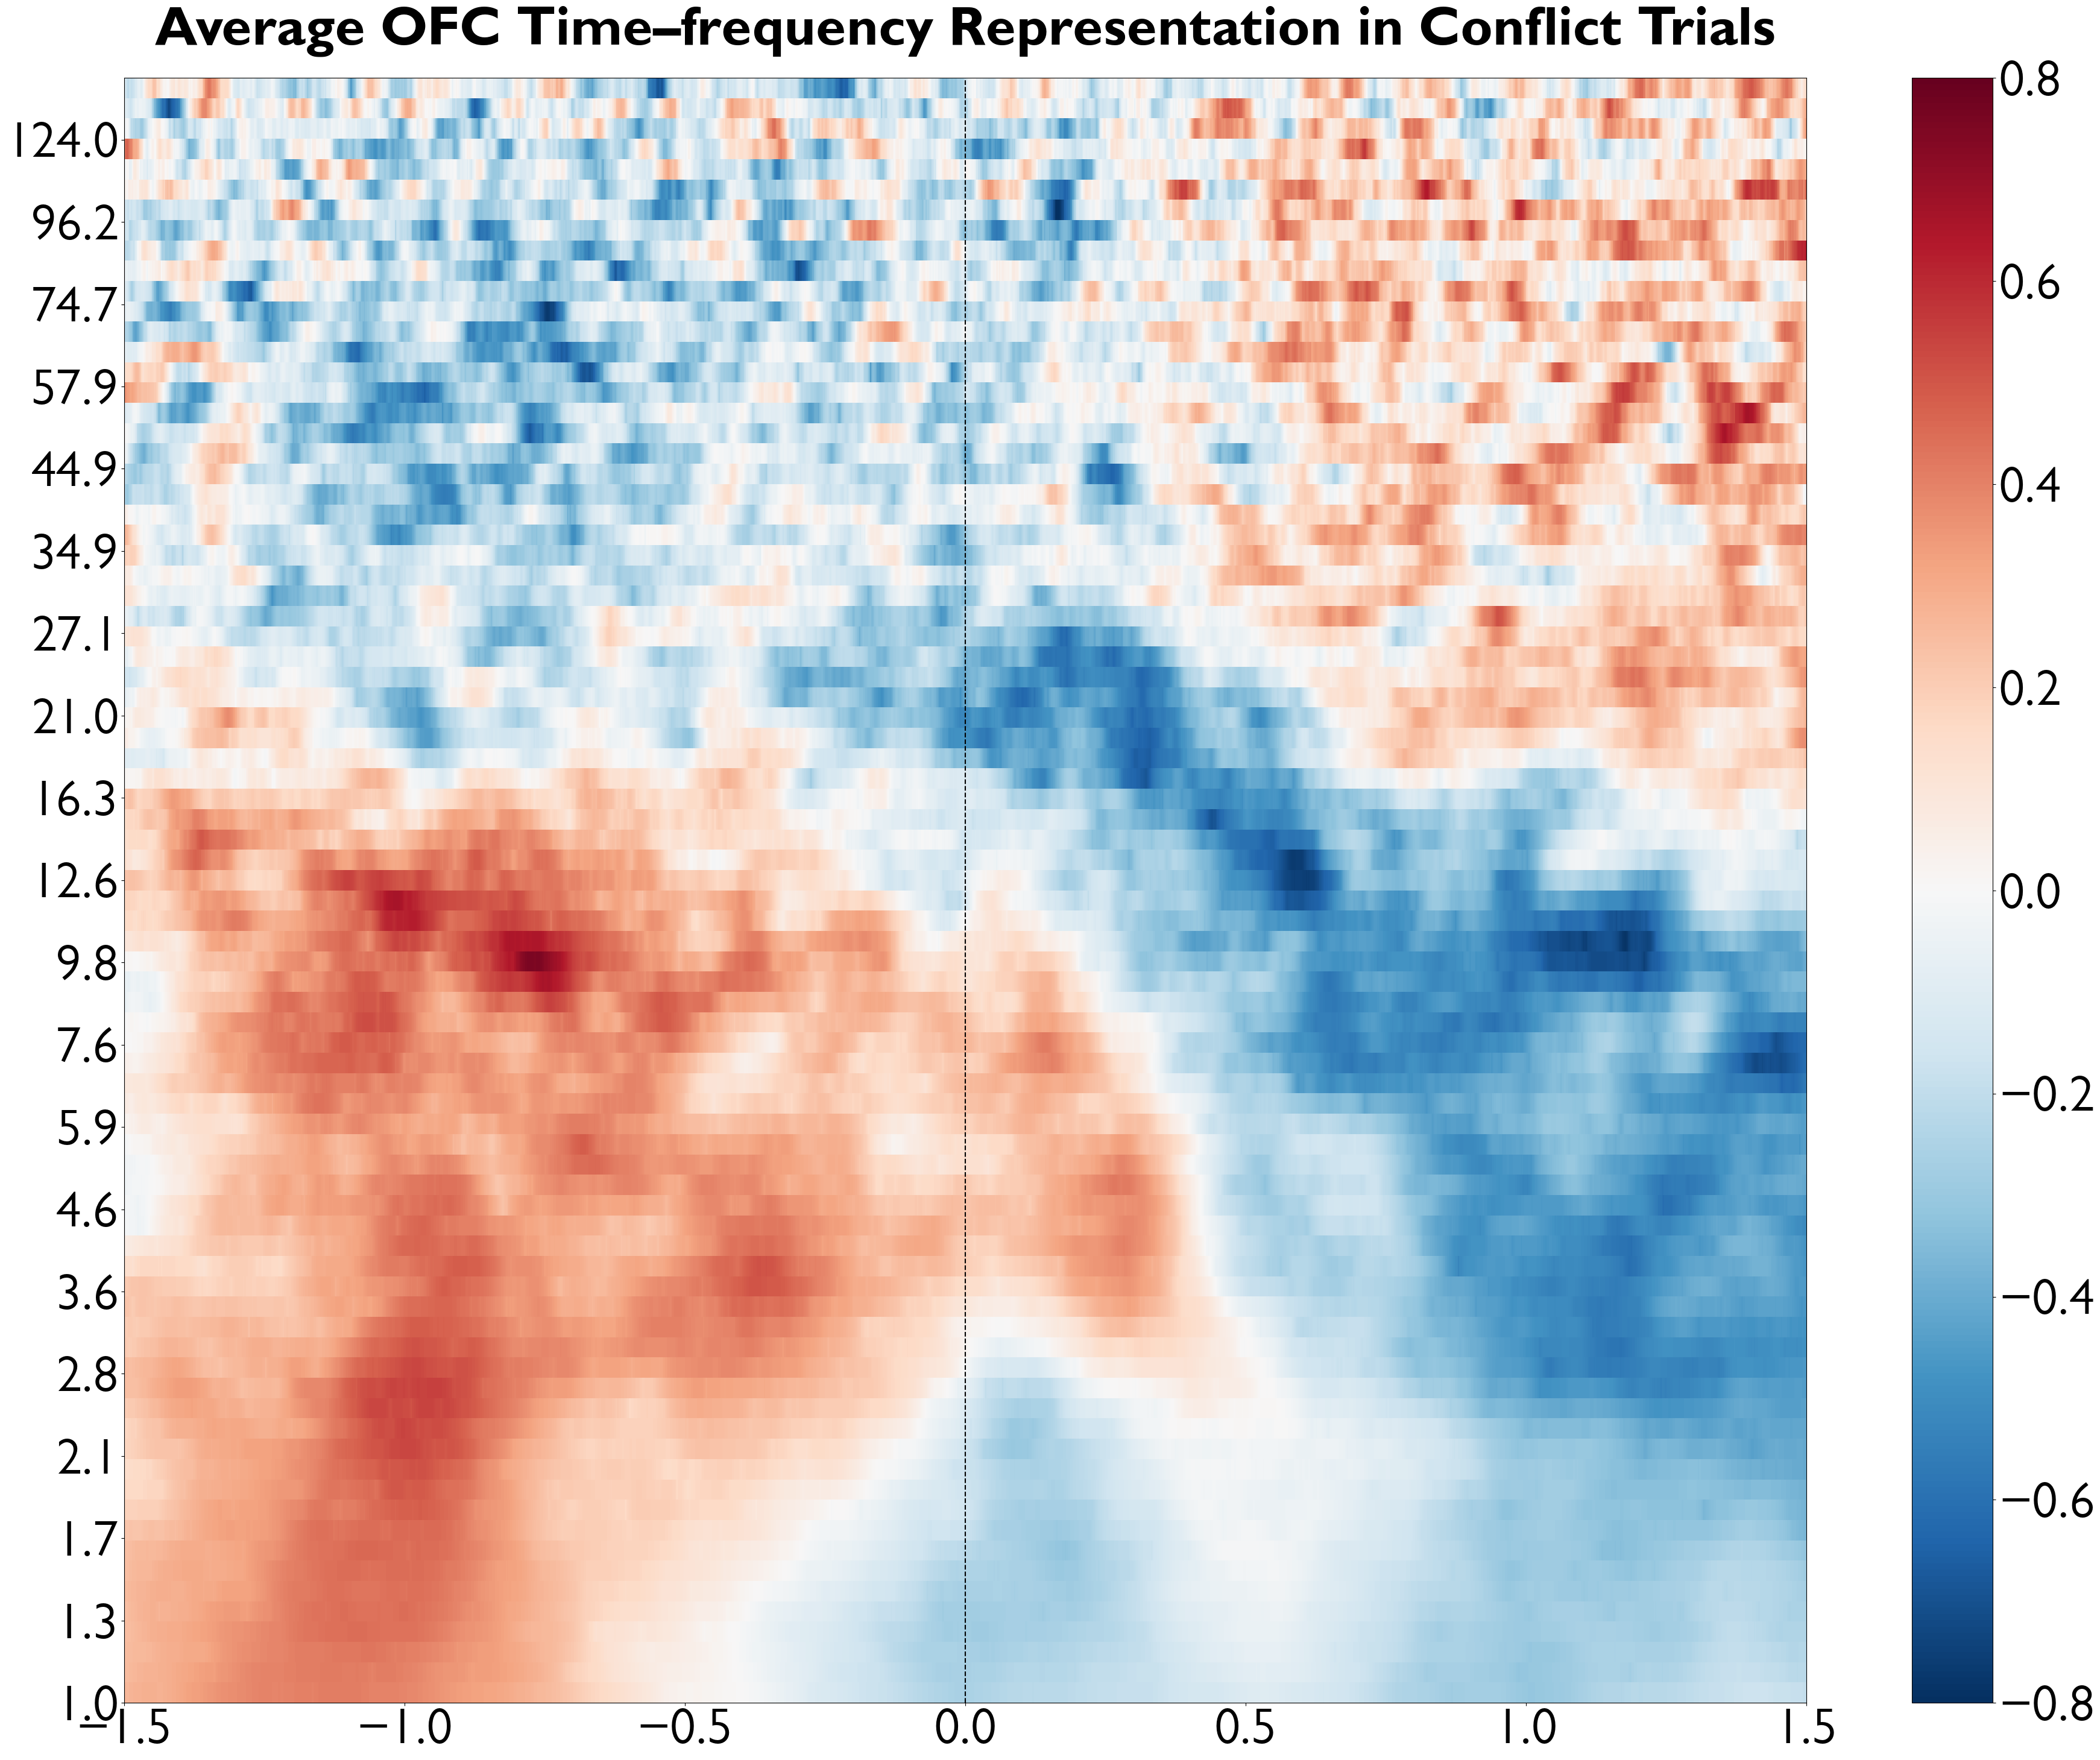

In [5]:
avg_tfr.plot_allsub_averages(all_subs_average_ofc_conflict, "Average OFC Time–frequency Representation in Conflict Trials", 'average_ofc_conflict_all_subs.png', -1.5, 1.5)

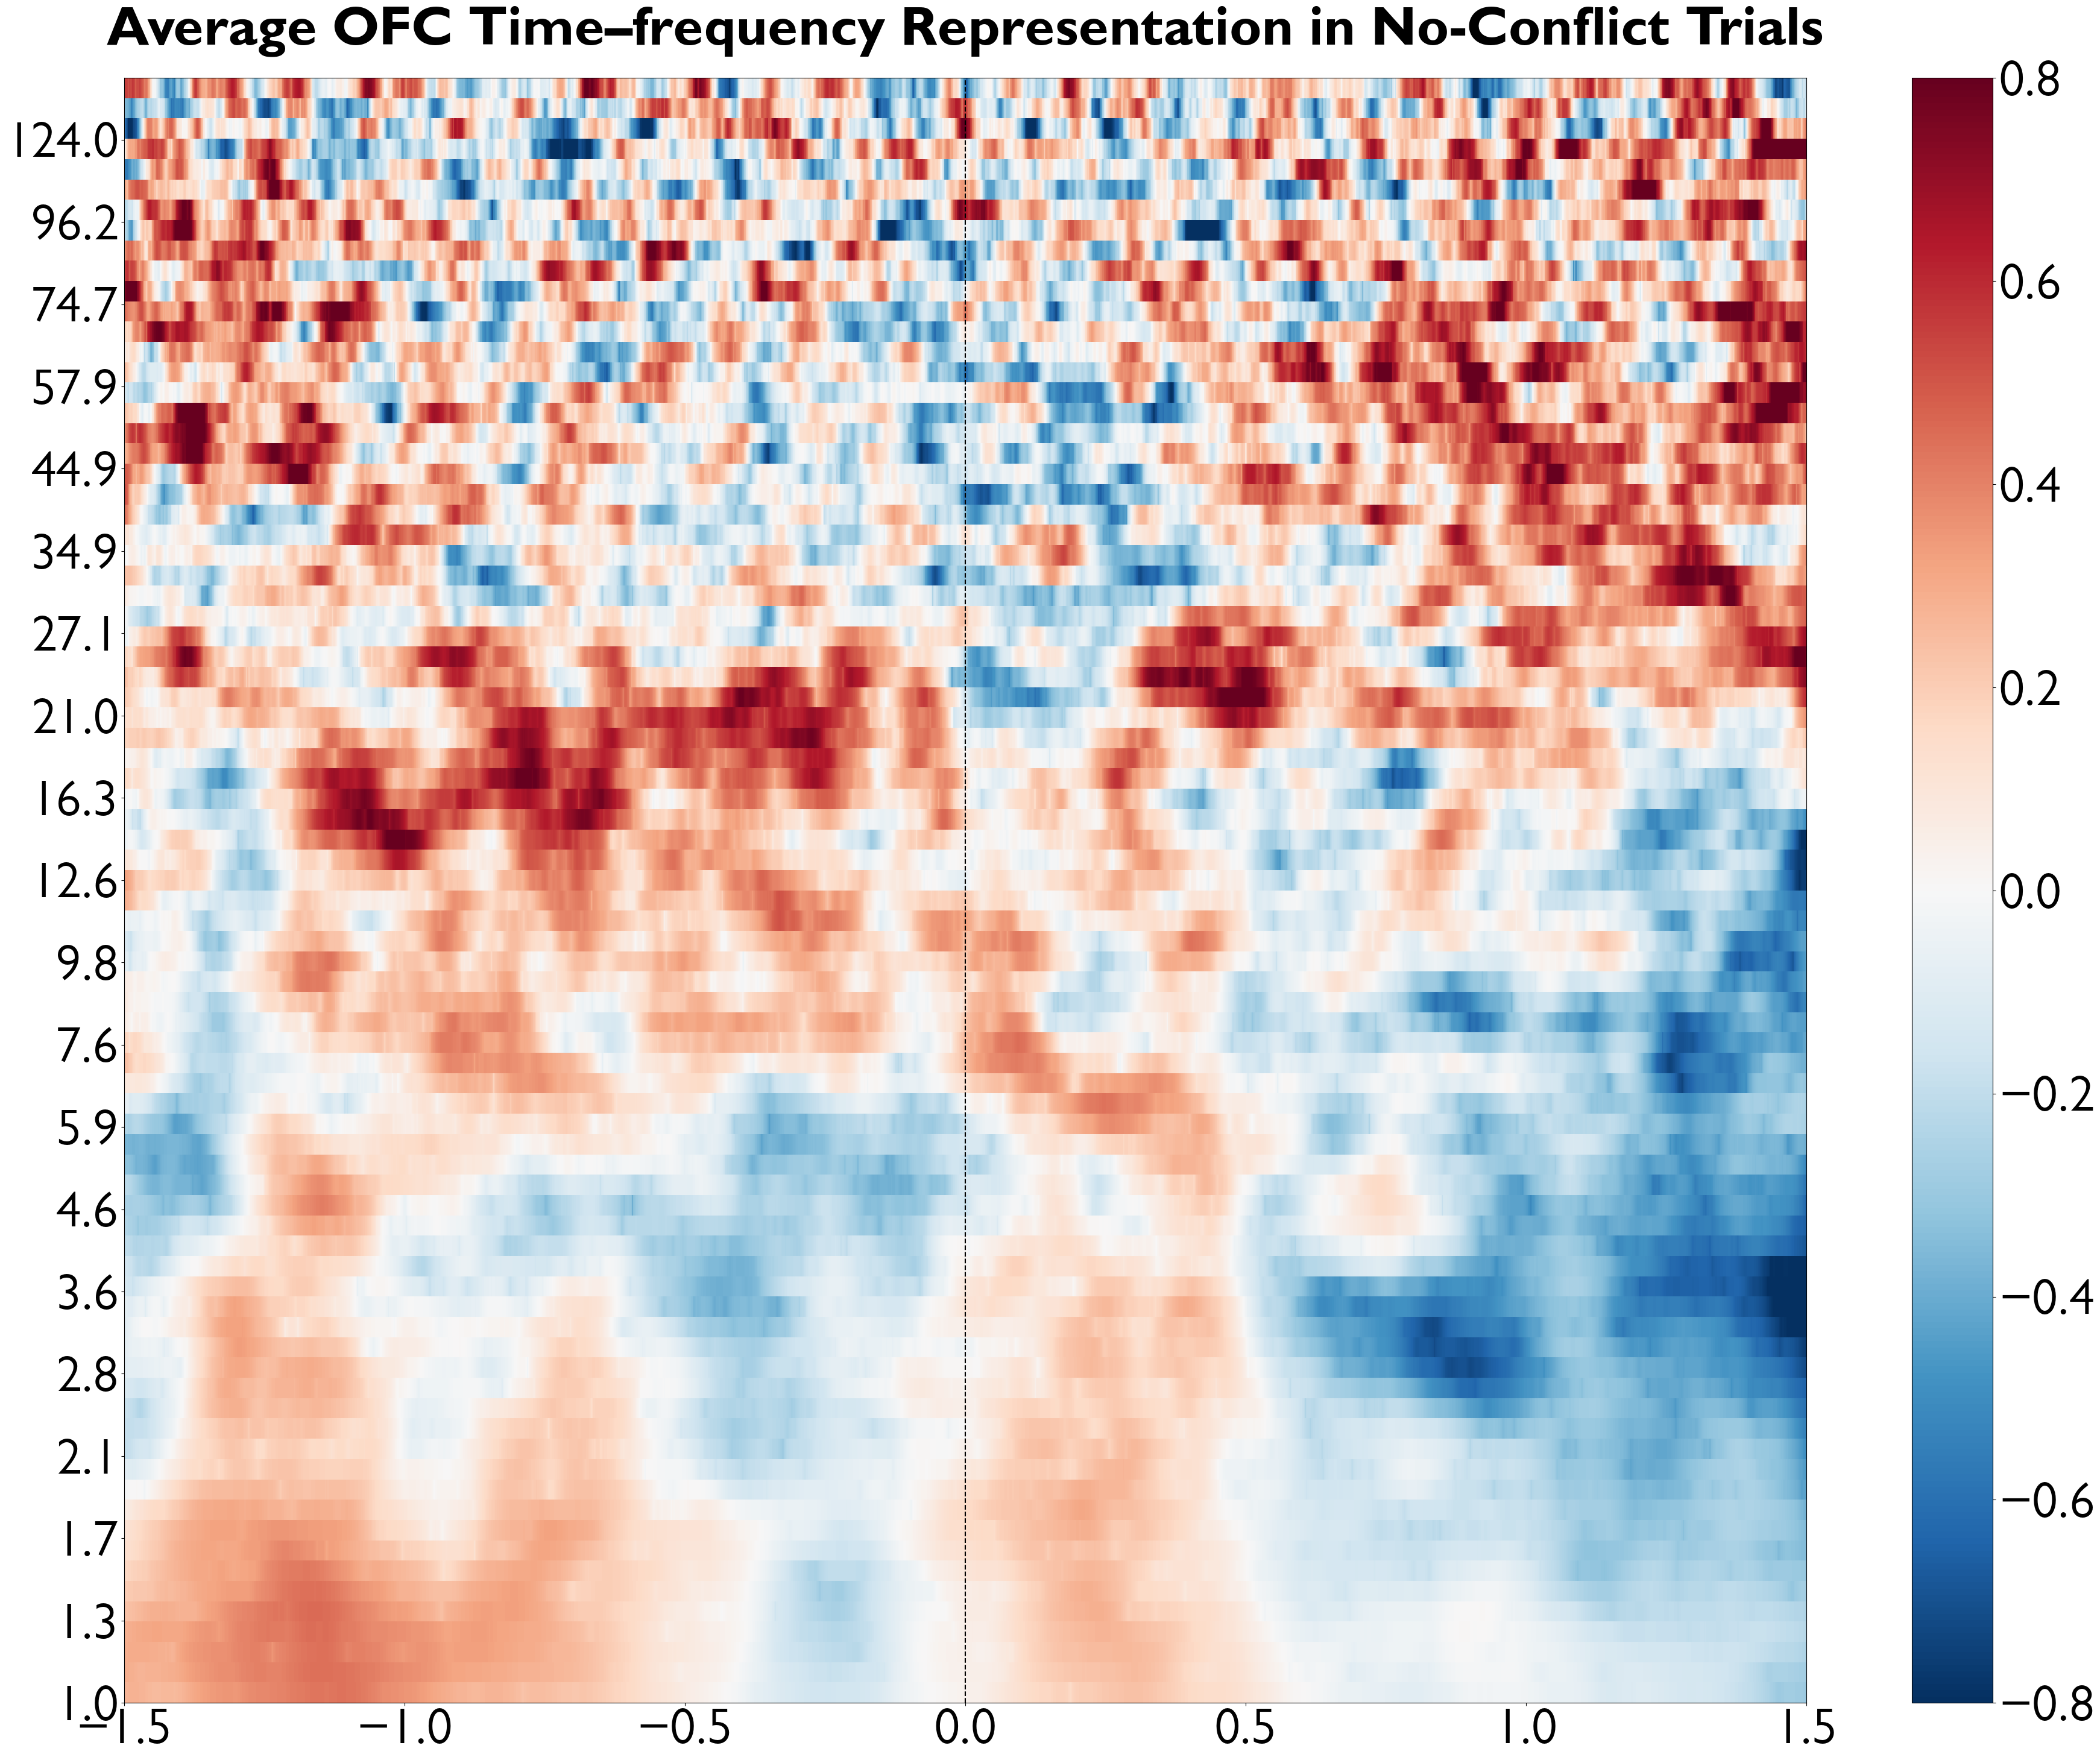

In [6]:
avg_tfr.plot_allsub_averages(all_subs_average_ofc_noconflict, "Average OFC Time–frequency Representation in No-Conflict Trials", 'average_ofc_noconflict_all_subs.png', -1.5, 1.5)

## Hippocampus

In [7]:
# subjects
new_sub_list = ['BJH017', 'BJH046', 'BJH050', 'SLCH018', 'BJH051']
old_sub_list = ['BJH021', 'BJH025', 'BJH016', 'SLCH002', 'BJH027', 'BJH029', 'BJH039', 'BJH041', 'LL10', 'LL12', 'LL13', 'LL14', 'LL17', 'LL19']

all_subs_average_hcs = calculate_last_away_new_sub_average(new_sub_list, old_sub_list, 'hc')

# separate averages #
all_subs_average_hc_conflict = all_subs_average_hcs[0]
all_subs_average_hc_noconflict = all_subs_average_hcs[1]


Reading /home/brooke/pacman/preprocessing/BJH017/ieeg/last_away/ghost-hc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH017/ieeg/last_away/noghost-hc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/ghost-hc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/noghost-hc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/ghost-hc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/noghost-hc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/SLCH018/ieeg/last_away/ghost-hc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/SLCH018/ieeg/last_away/noghost-hc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/ghost-hc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/noghost-hc-tfr.h5 ...


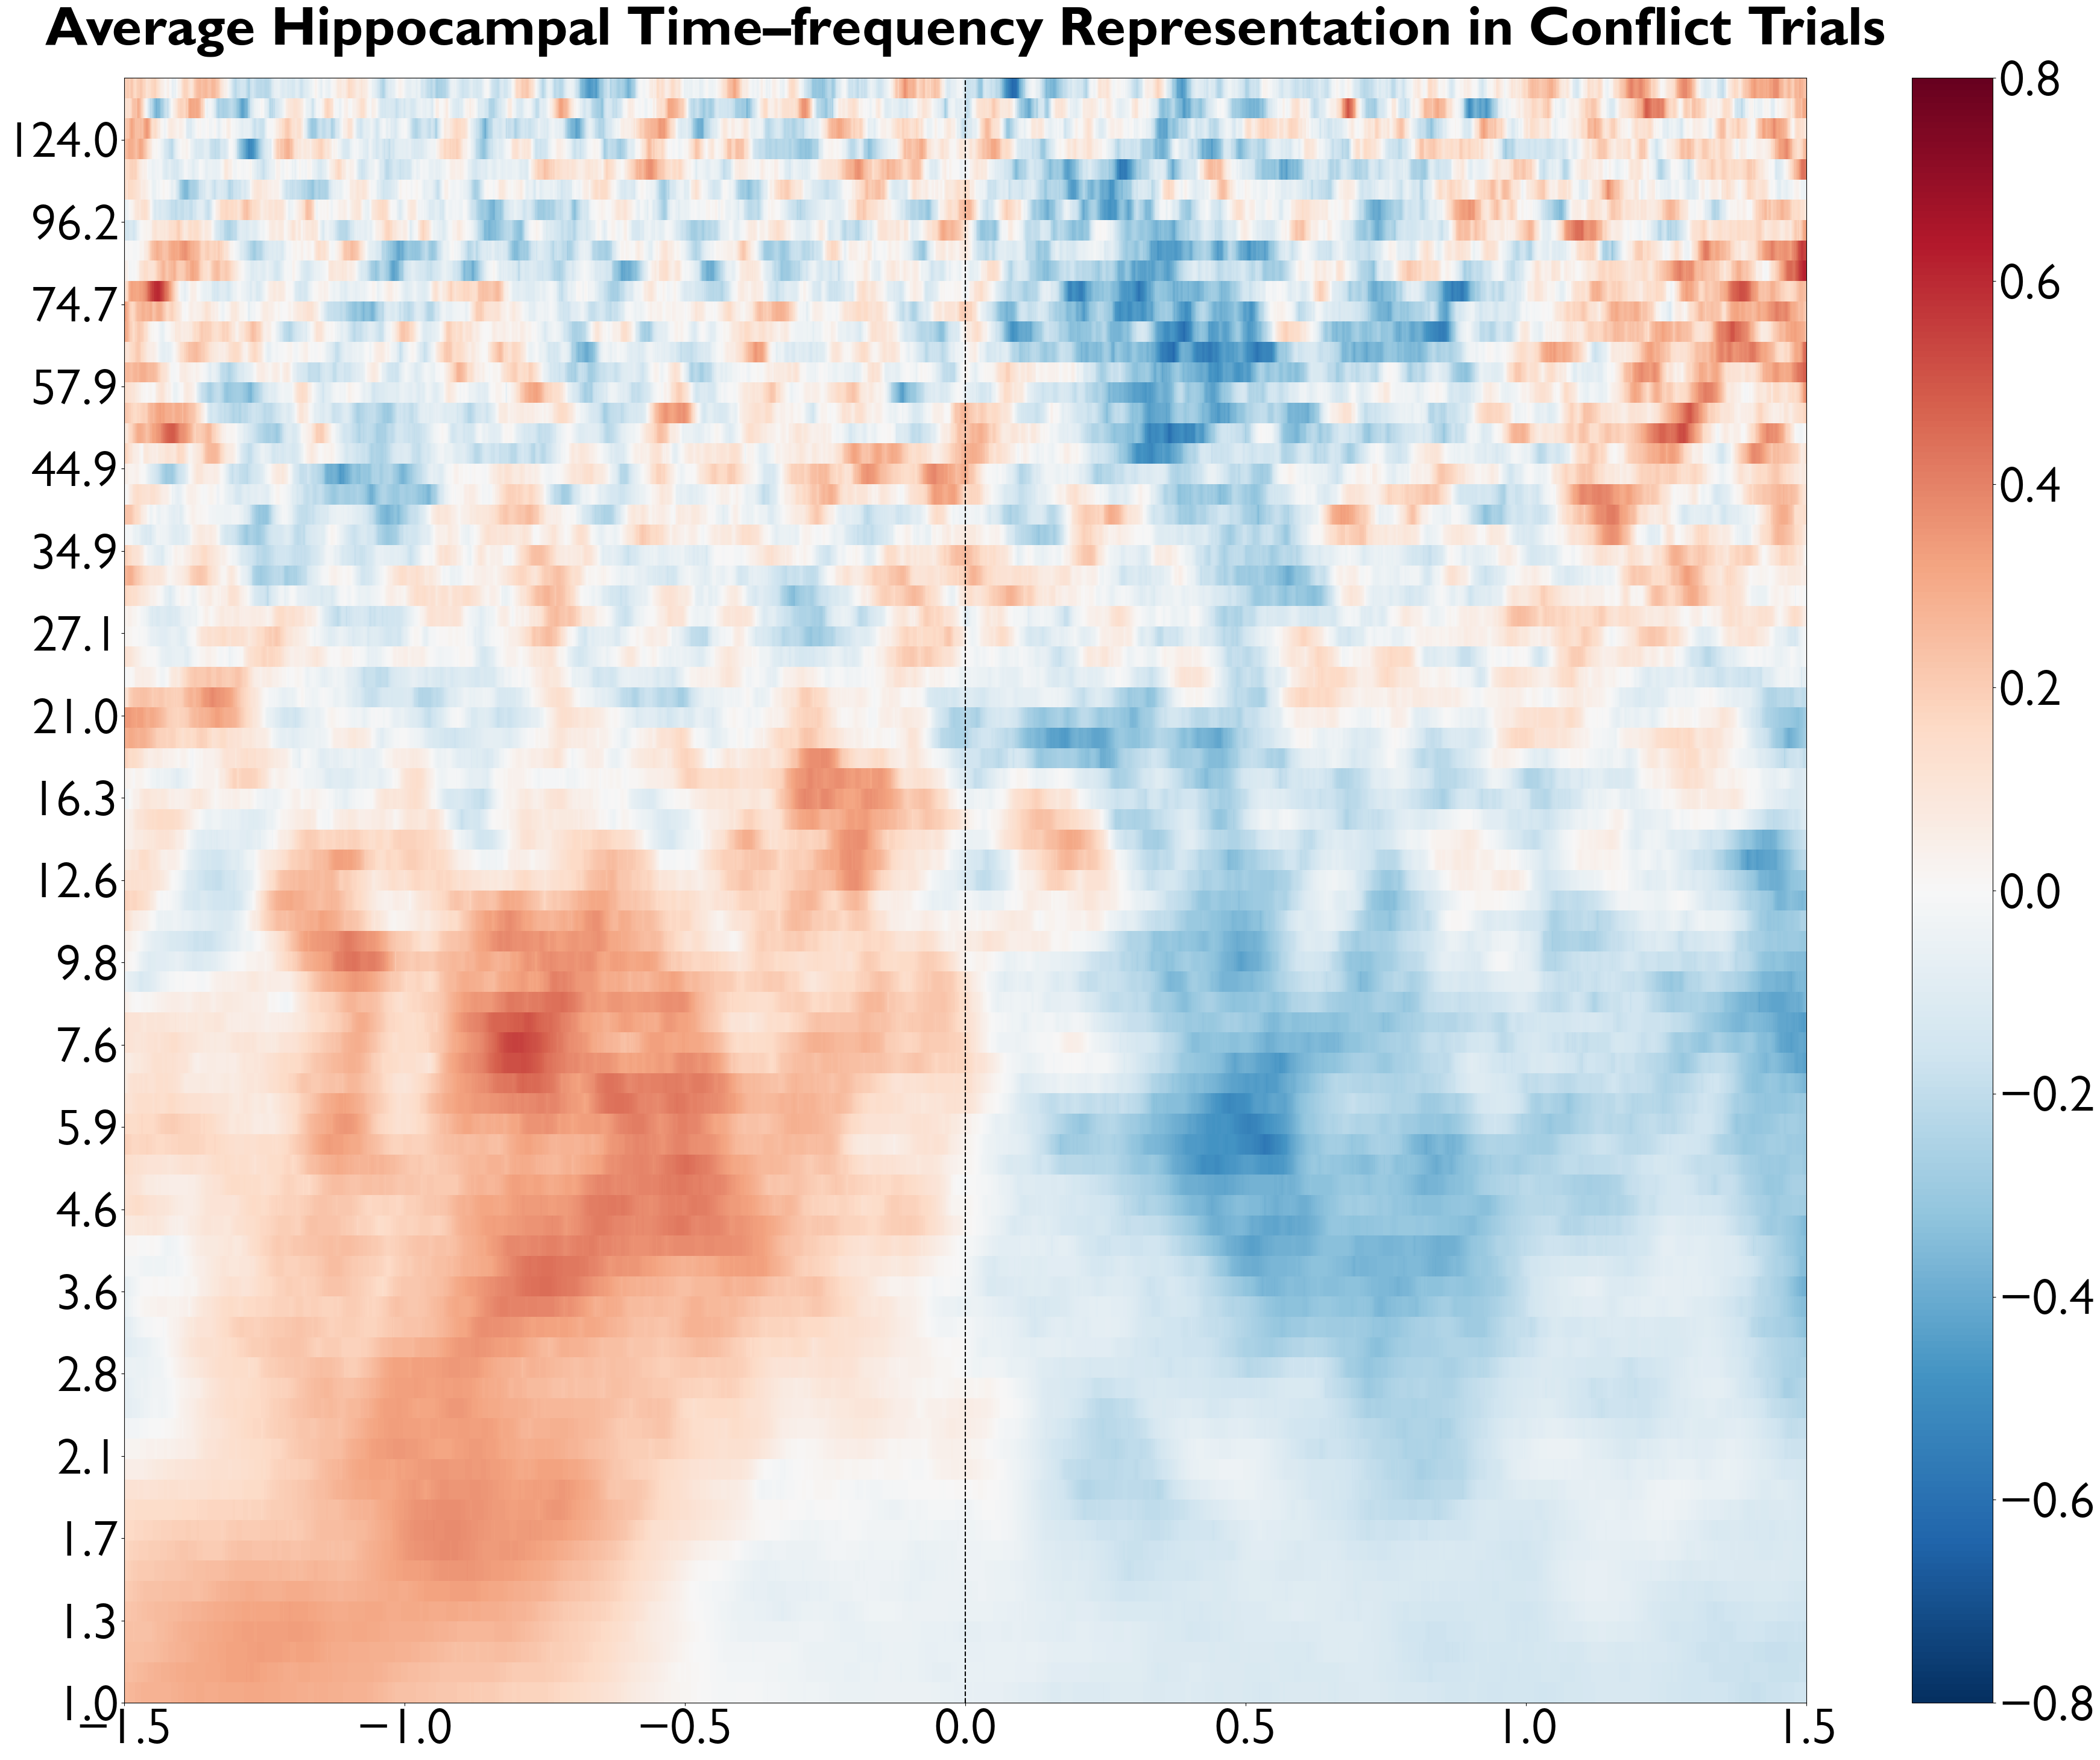

In [8]:
avg_tfr.plot_allsub_averages(all_subs_average_hc_conflict, "Average Hippocampal Time–frequency Representation in Conflict Trials", 'average_hc_conflict_all_subs.png', -1.5, 1.5)

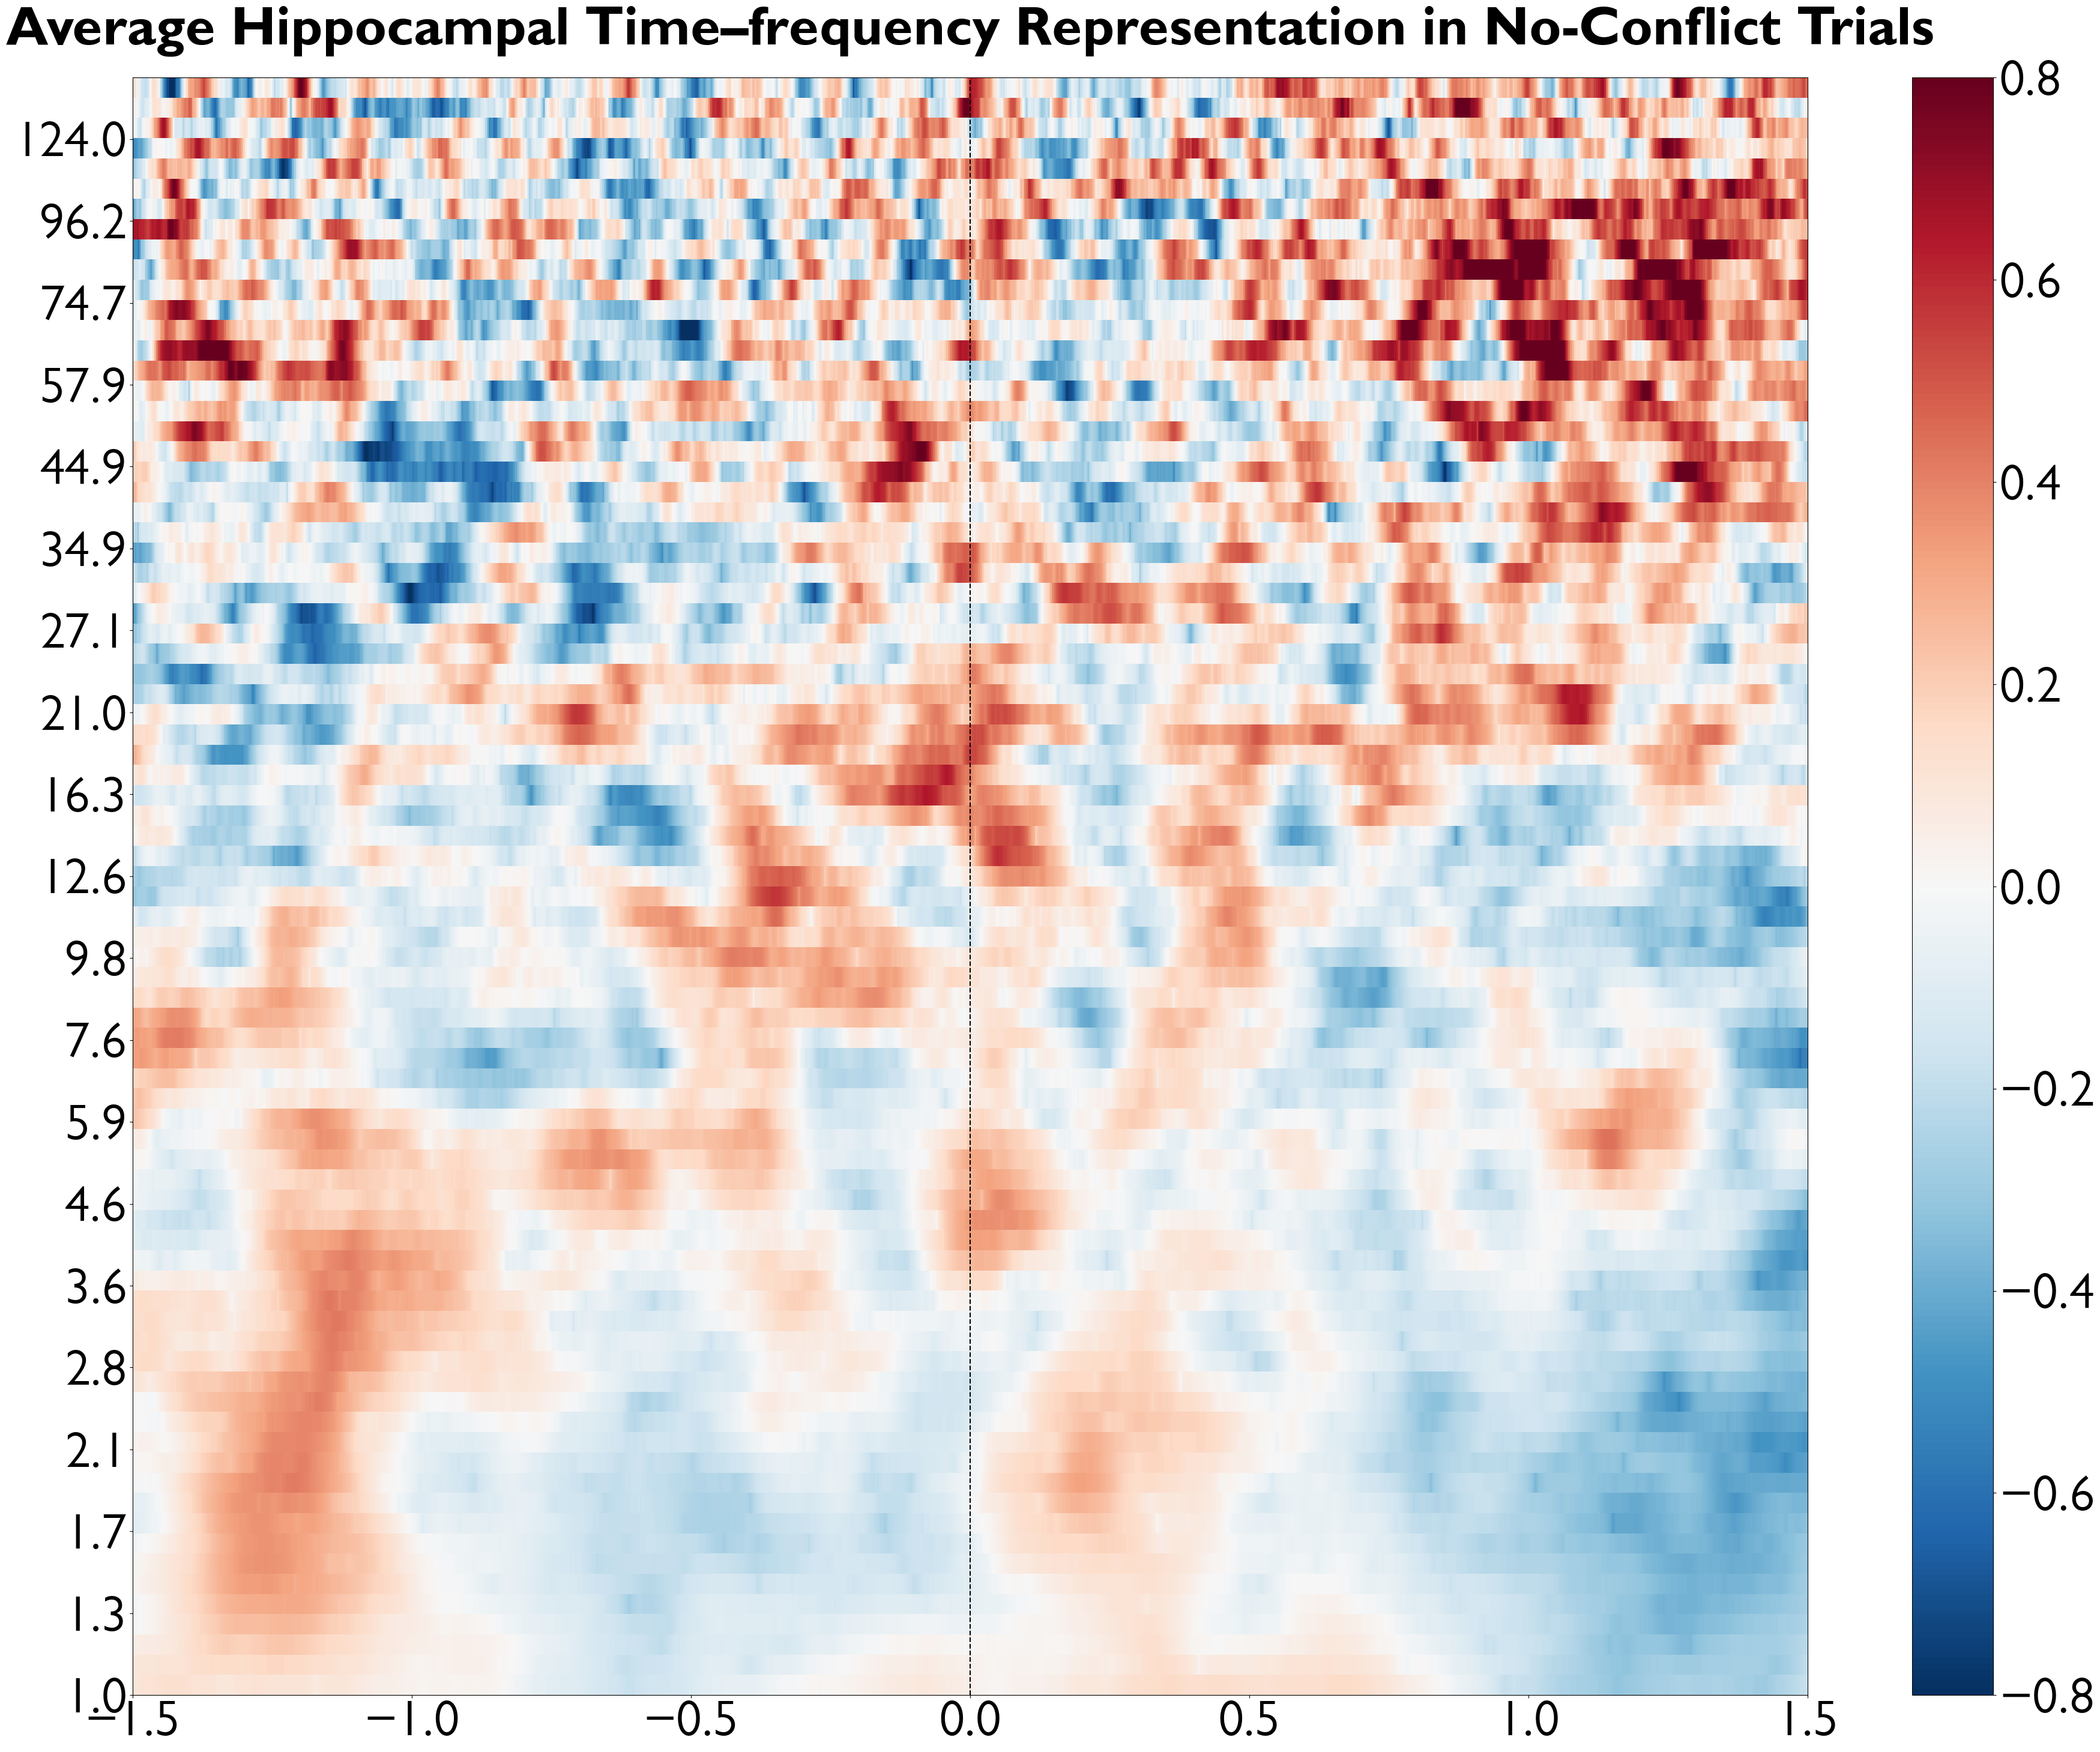

In [9]:
avg_tfr.plot_allsub_averages(all_subs_average_hc_noconflict, "Average Hippocampal Time–frequency Representation in No-Conflict Trials", 'average_hc_noconflict_all_subs.png', -1.5, 1.5)

## Anterior Cingulate

In [46]:
# subjects
new_sub_list = ['BJH017', 'BJH046', 'BJH050', 'BJH051'] 
old_sub_list = ['BJH021', 'BJH025', 'BJH016', 'SLCH002', 'BJH026', 'BJH039', 'LL10', 'LL12', 'LL13', 'LL17', 'LL19']


all_subs_average_accs = calculate_last_away_new_sub_average(new_sub_list, old_sub_list, 'cing')

# separate averages #
all_subs_average_acc_conflict = all_subs_average_accs[0]
all_subs_average_acc_noconflict = all_subs_average_accs[1]


Reading /home/brooke/pacman/preprocessing/BJH017/ieeg/last_away/ghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH017/ieeg/last_away/noghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/ghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/noghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/ghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/noghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/ghost-cing-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/noghost-cing-tfr.h5 ...


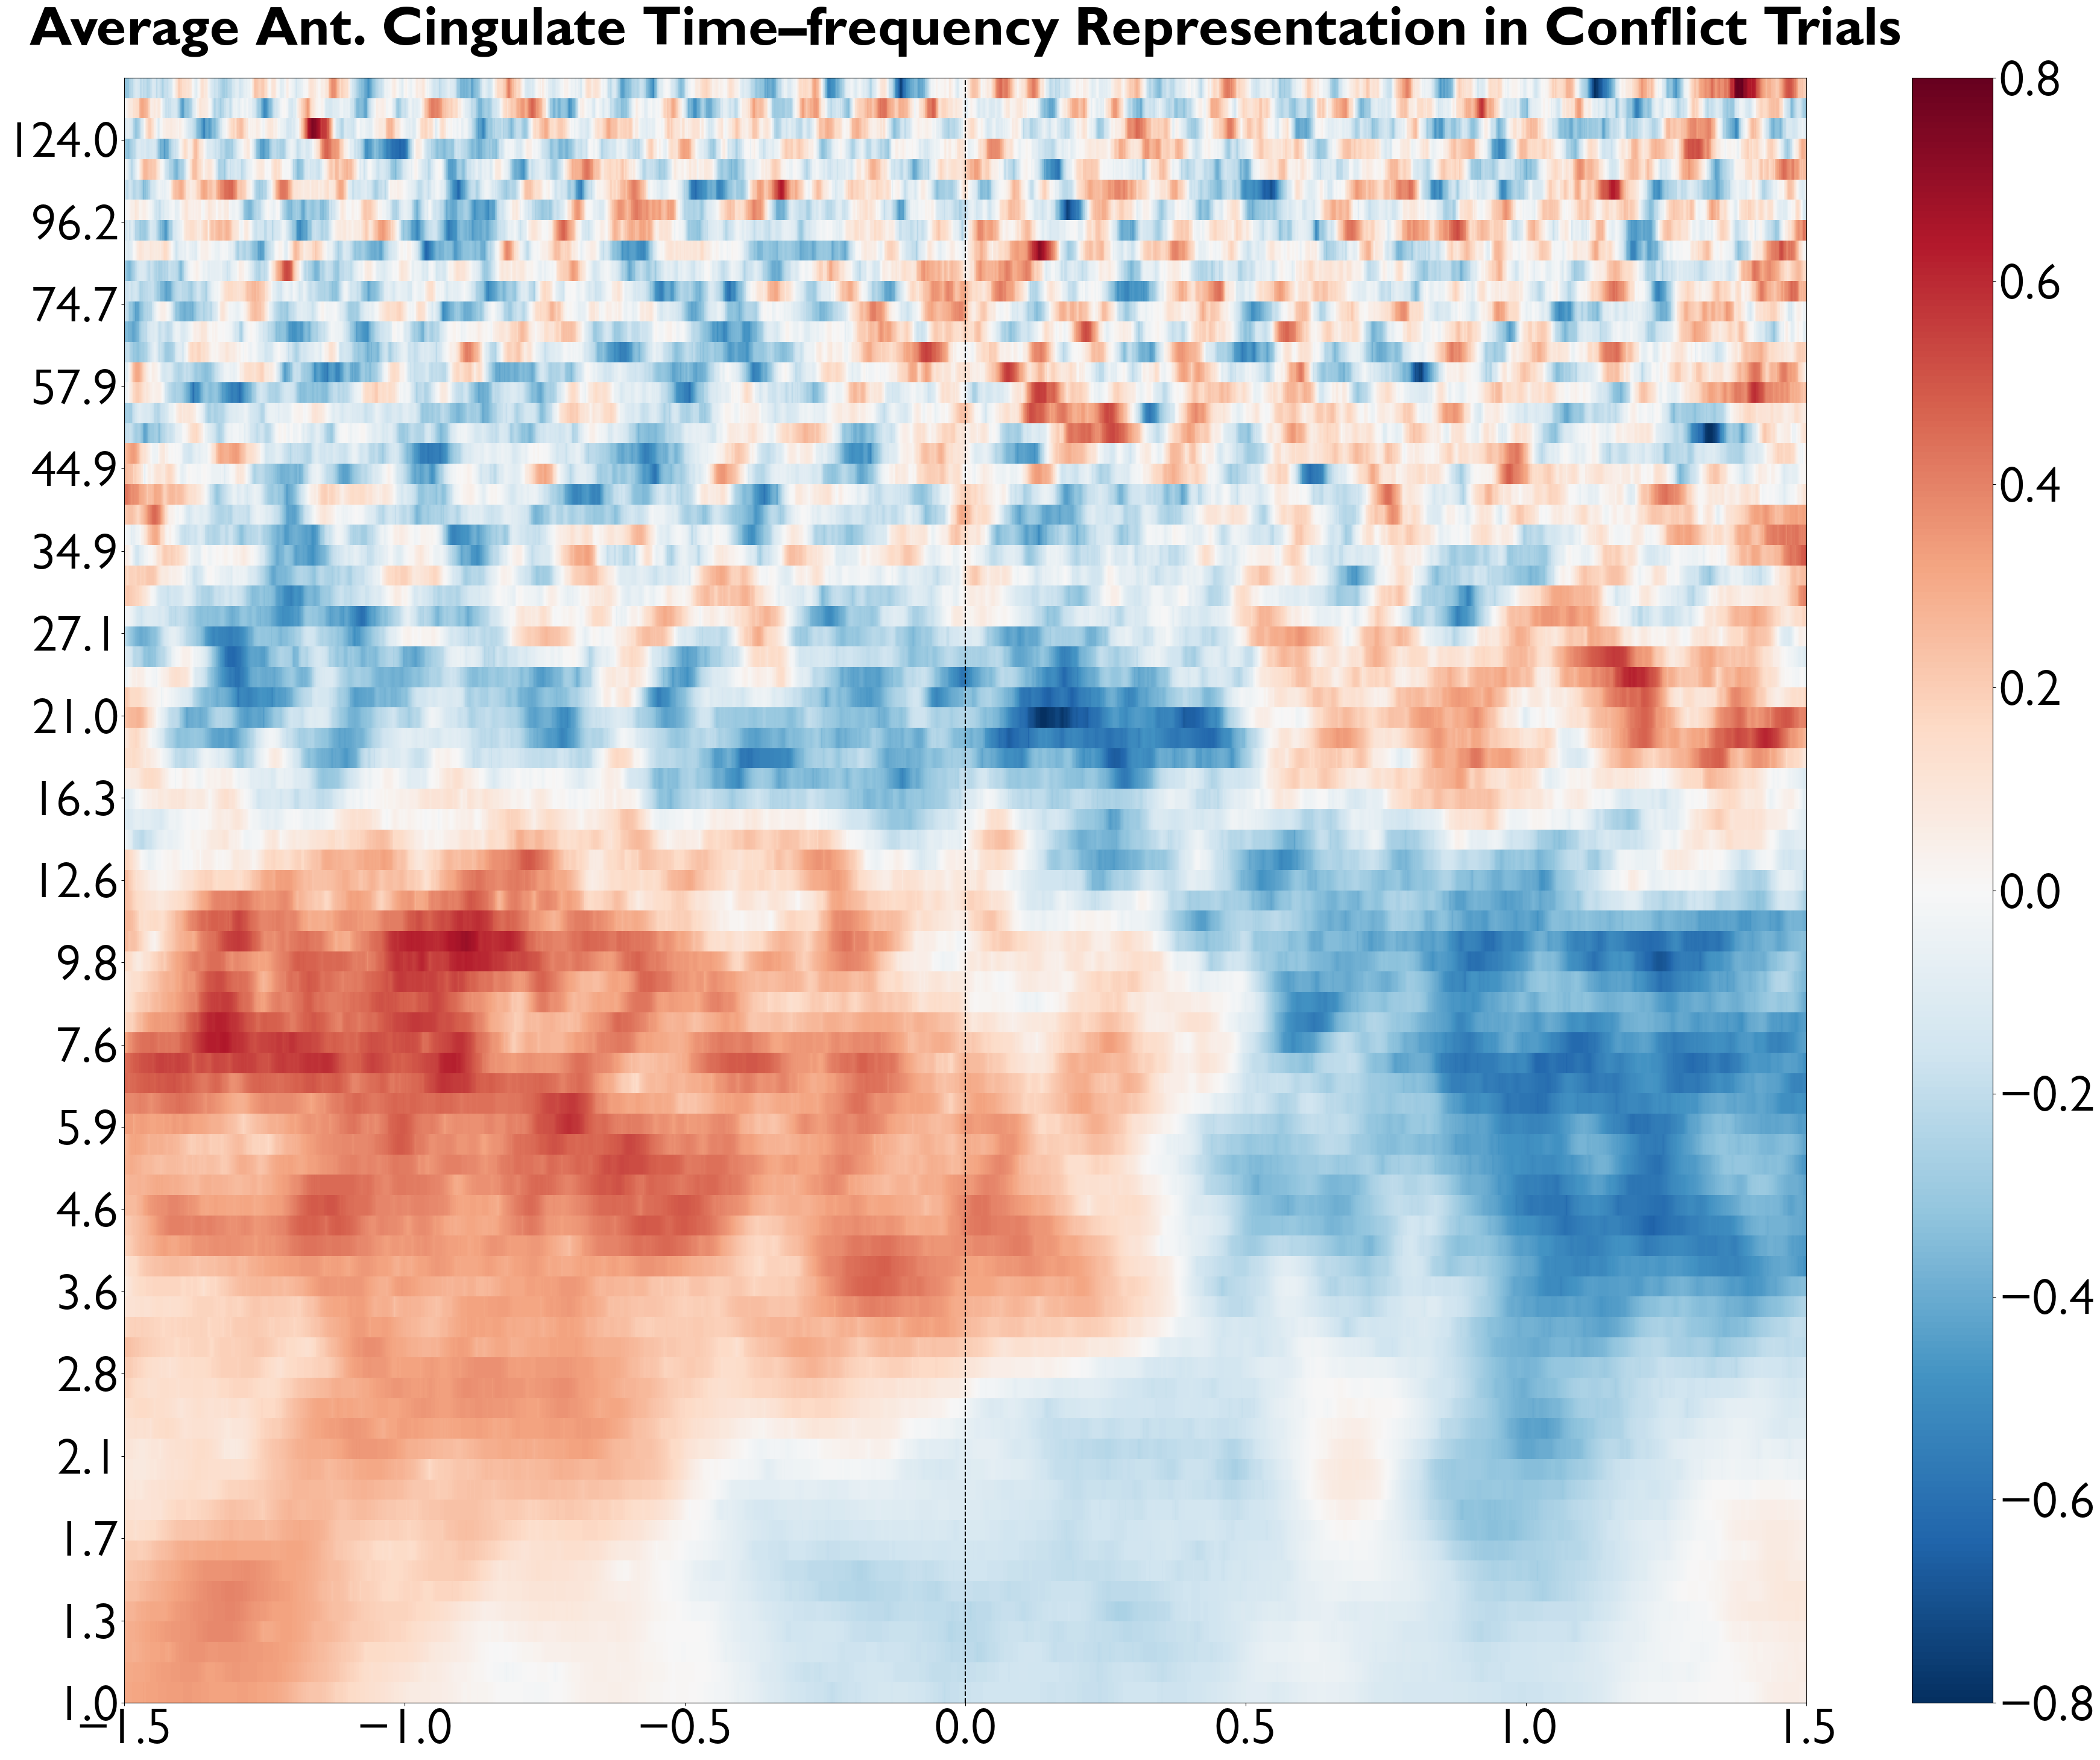

In [47]:
avg_tfr.plot_allsub_averages(all_subs_average_acc_conflict, "Average Ant. Cingulate Time–frequency Representation in Conflict Trials", 'average_cing_conflict_all_subs.png', -1.5, 1.5)

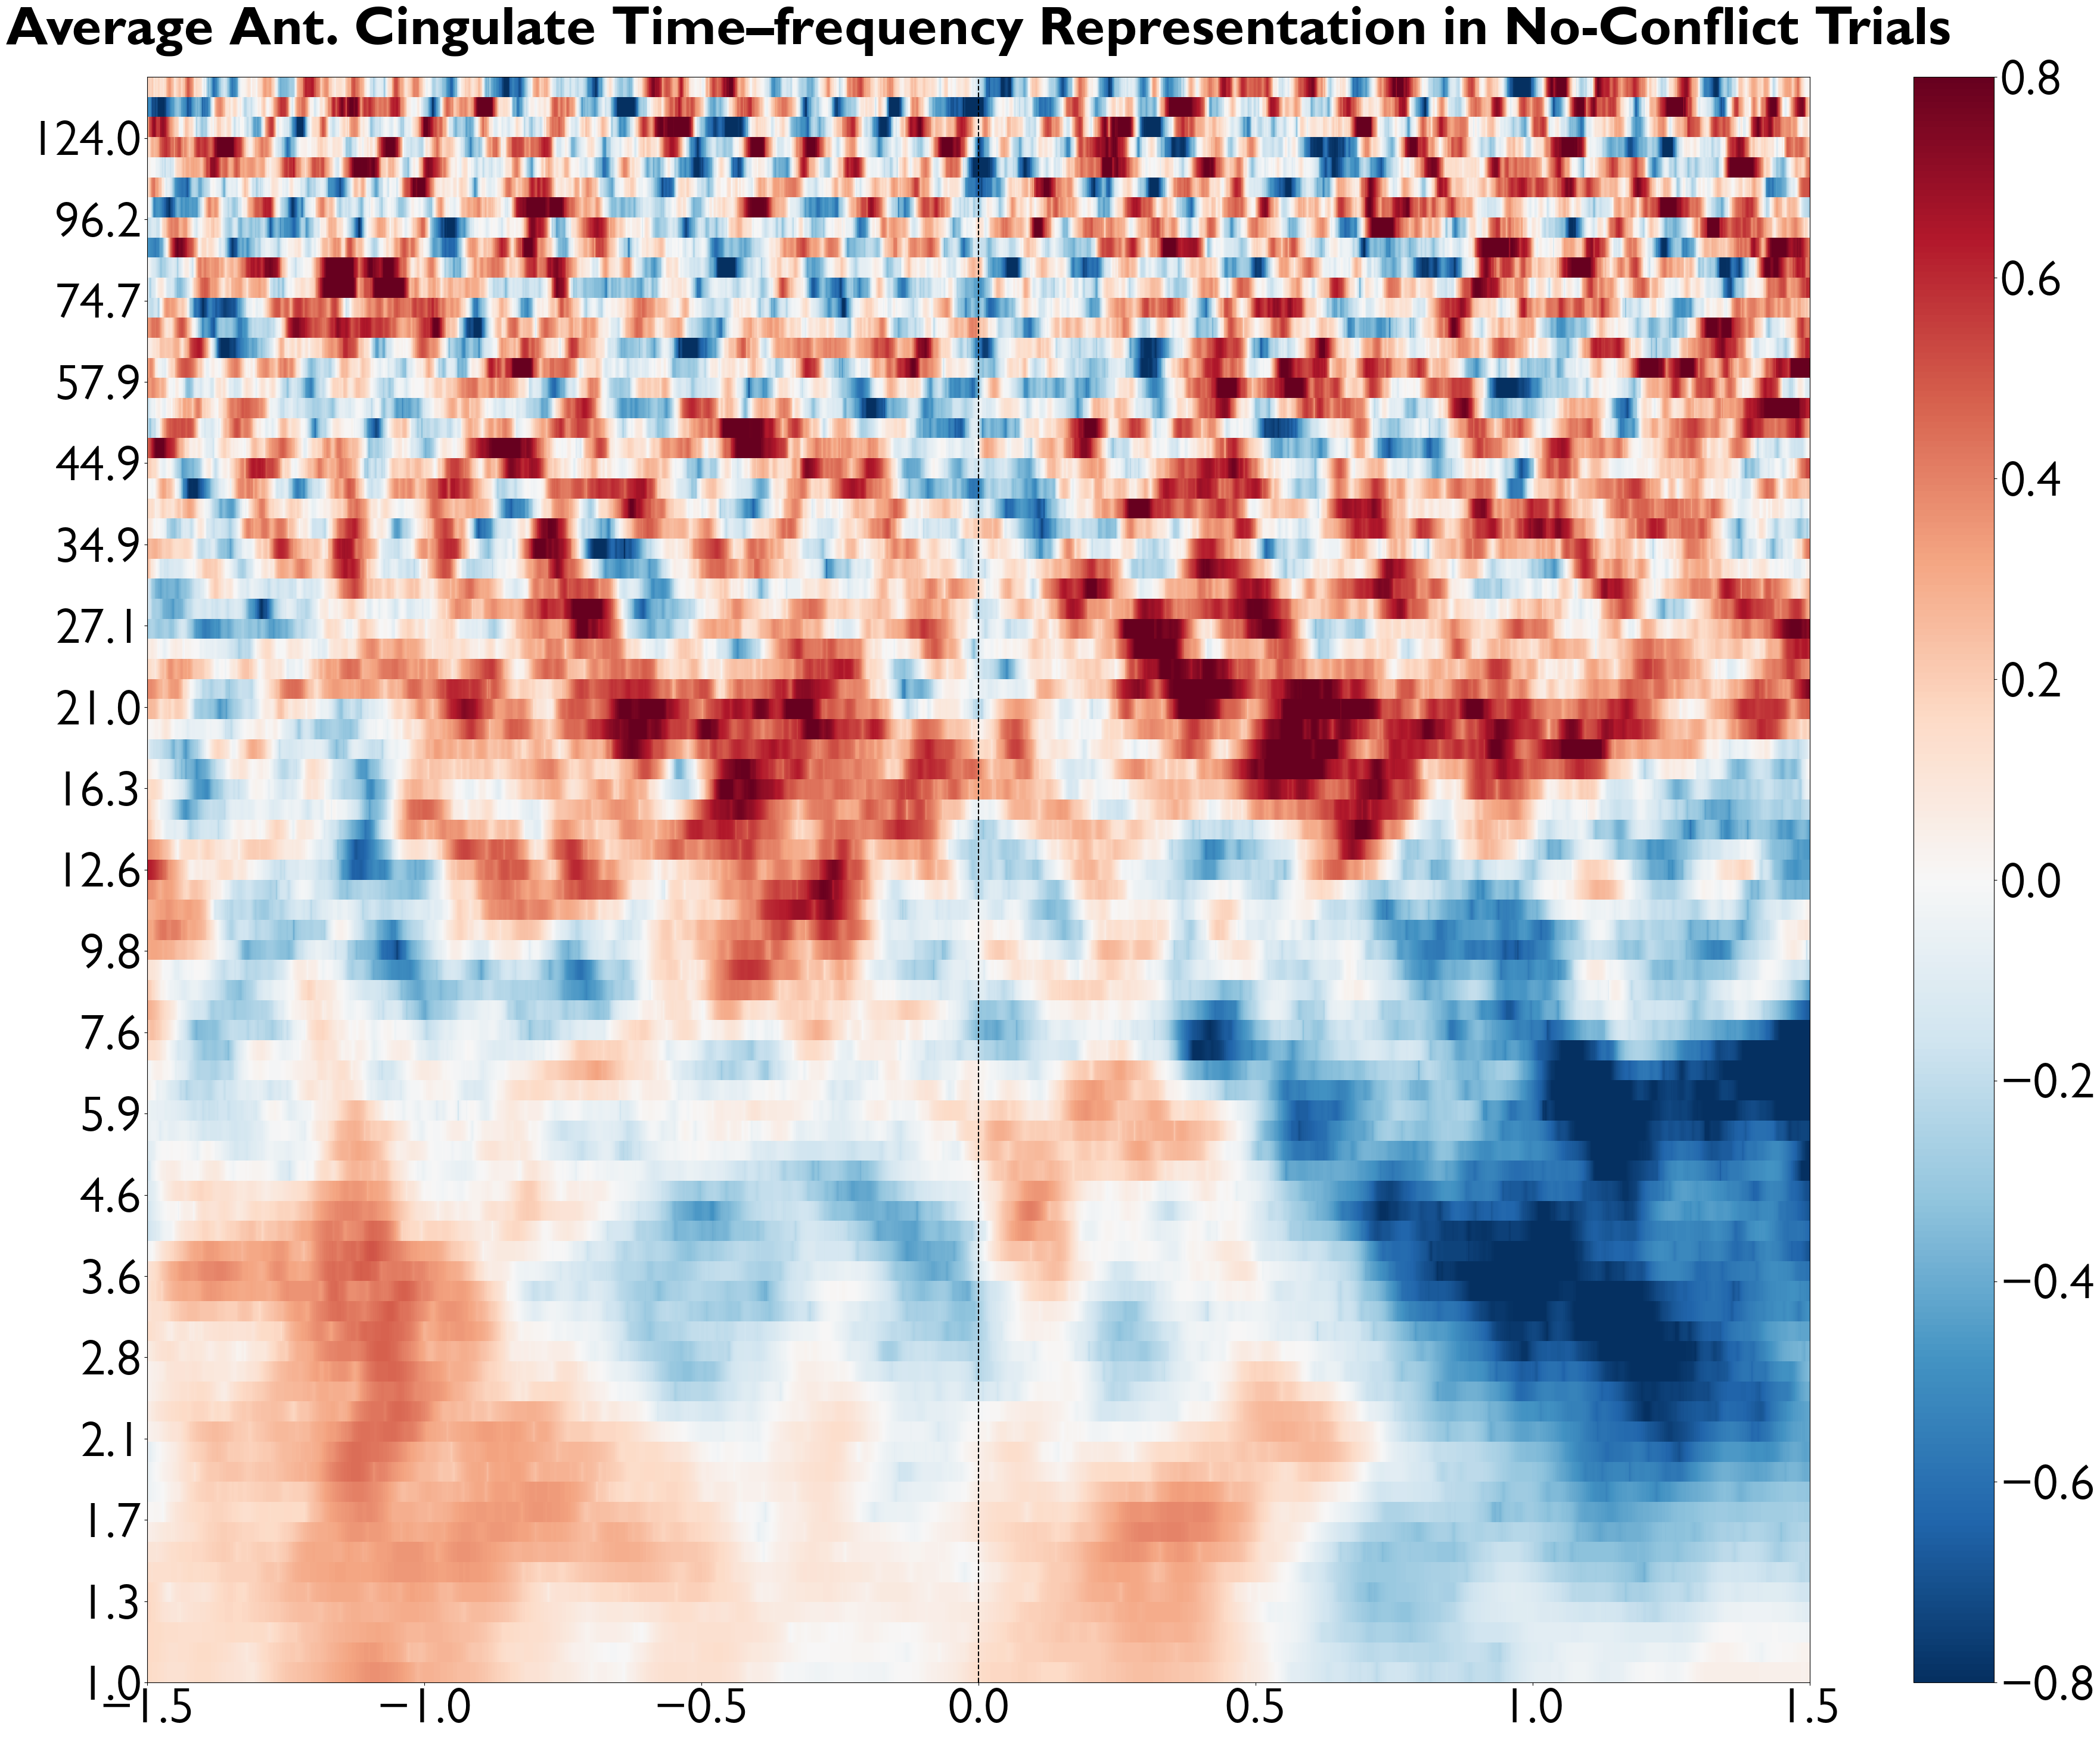

In [48]:
avg_tfr.plot_allsub_averages(all_subs_average_acc_noconflict, "Average Ant. Cingulate Time–frequency Representation in No-Conflict Trials", 'average_cing_noconflict_all_subs.png', -1.5, 1.5)

## Amygdala

In [49]:
# subjects
new_sub_list = ['BJH017', 'BJH046', 'BJH050', 'SLCH018', 'BJH051'] 
old_sub_list = ['BJH021', 'BJH025', 'BJH016', 'SLCH002', 'BJH026', 'BJH027', 'BJH029', 'BJH039', 'BJH041', 'LL10', 'LL12', 'LL13', 'LL14', 'LL17', 'LL19']

all_subs_average_amygs = calculate_last_away_new_sub_average(new_sub_list, old_sub_list, 'amyg')

# separate averages #
all_subs_average_amyg_conflict = all_subs_average_amygs[0]
all_subs_average_amyg_noconflict = all_subs_average_amygs[1]


Reading /home/brooke/pacman/preprocessing/BJH017/ieeg/last_away/ghost-amyg-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH017/ieeg/last_away/noghost-amyg-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/ghost-amyg-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/noghost-amyg-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/ghost-amyg-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/noghost-amyg-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/SLCH018/ieeg/last_away/ghost-amyg-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/SLCH018/ieeg/last_away/noghost-amyg-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/ghost-amyg-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/noghost-amyg-tfr.h5 ...


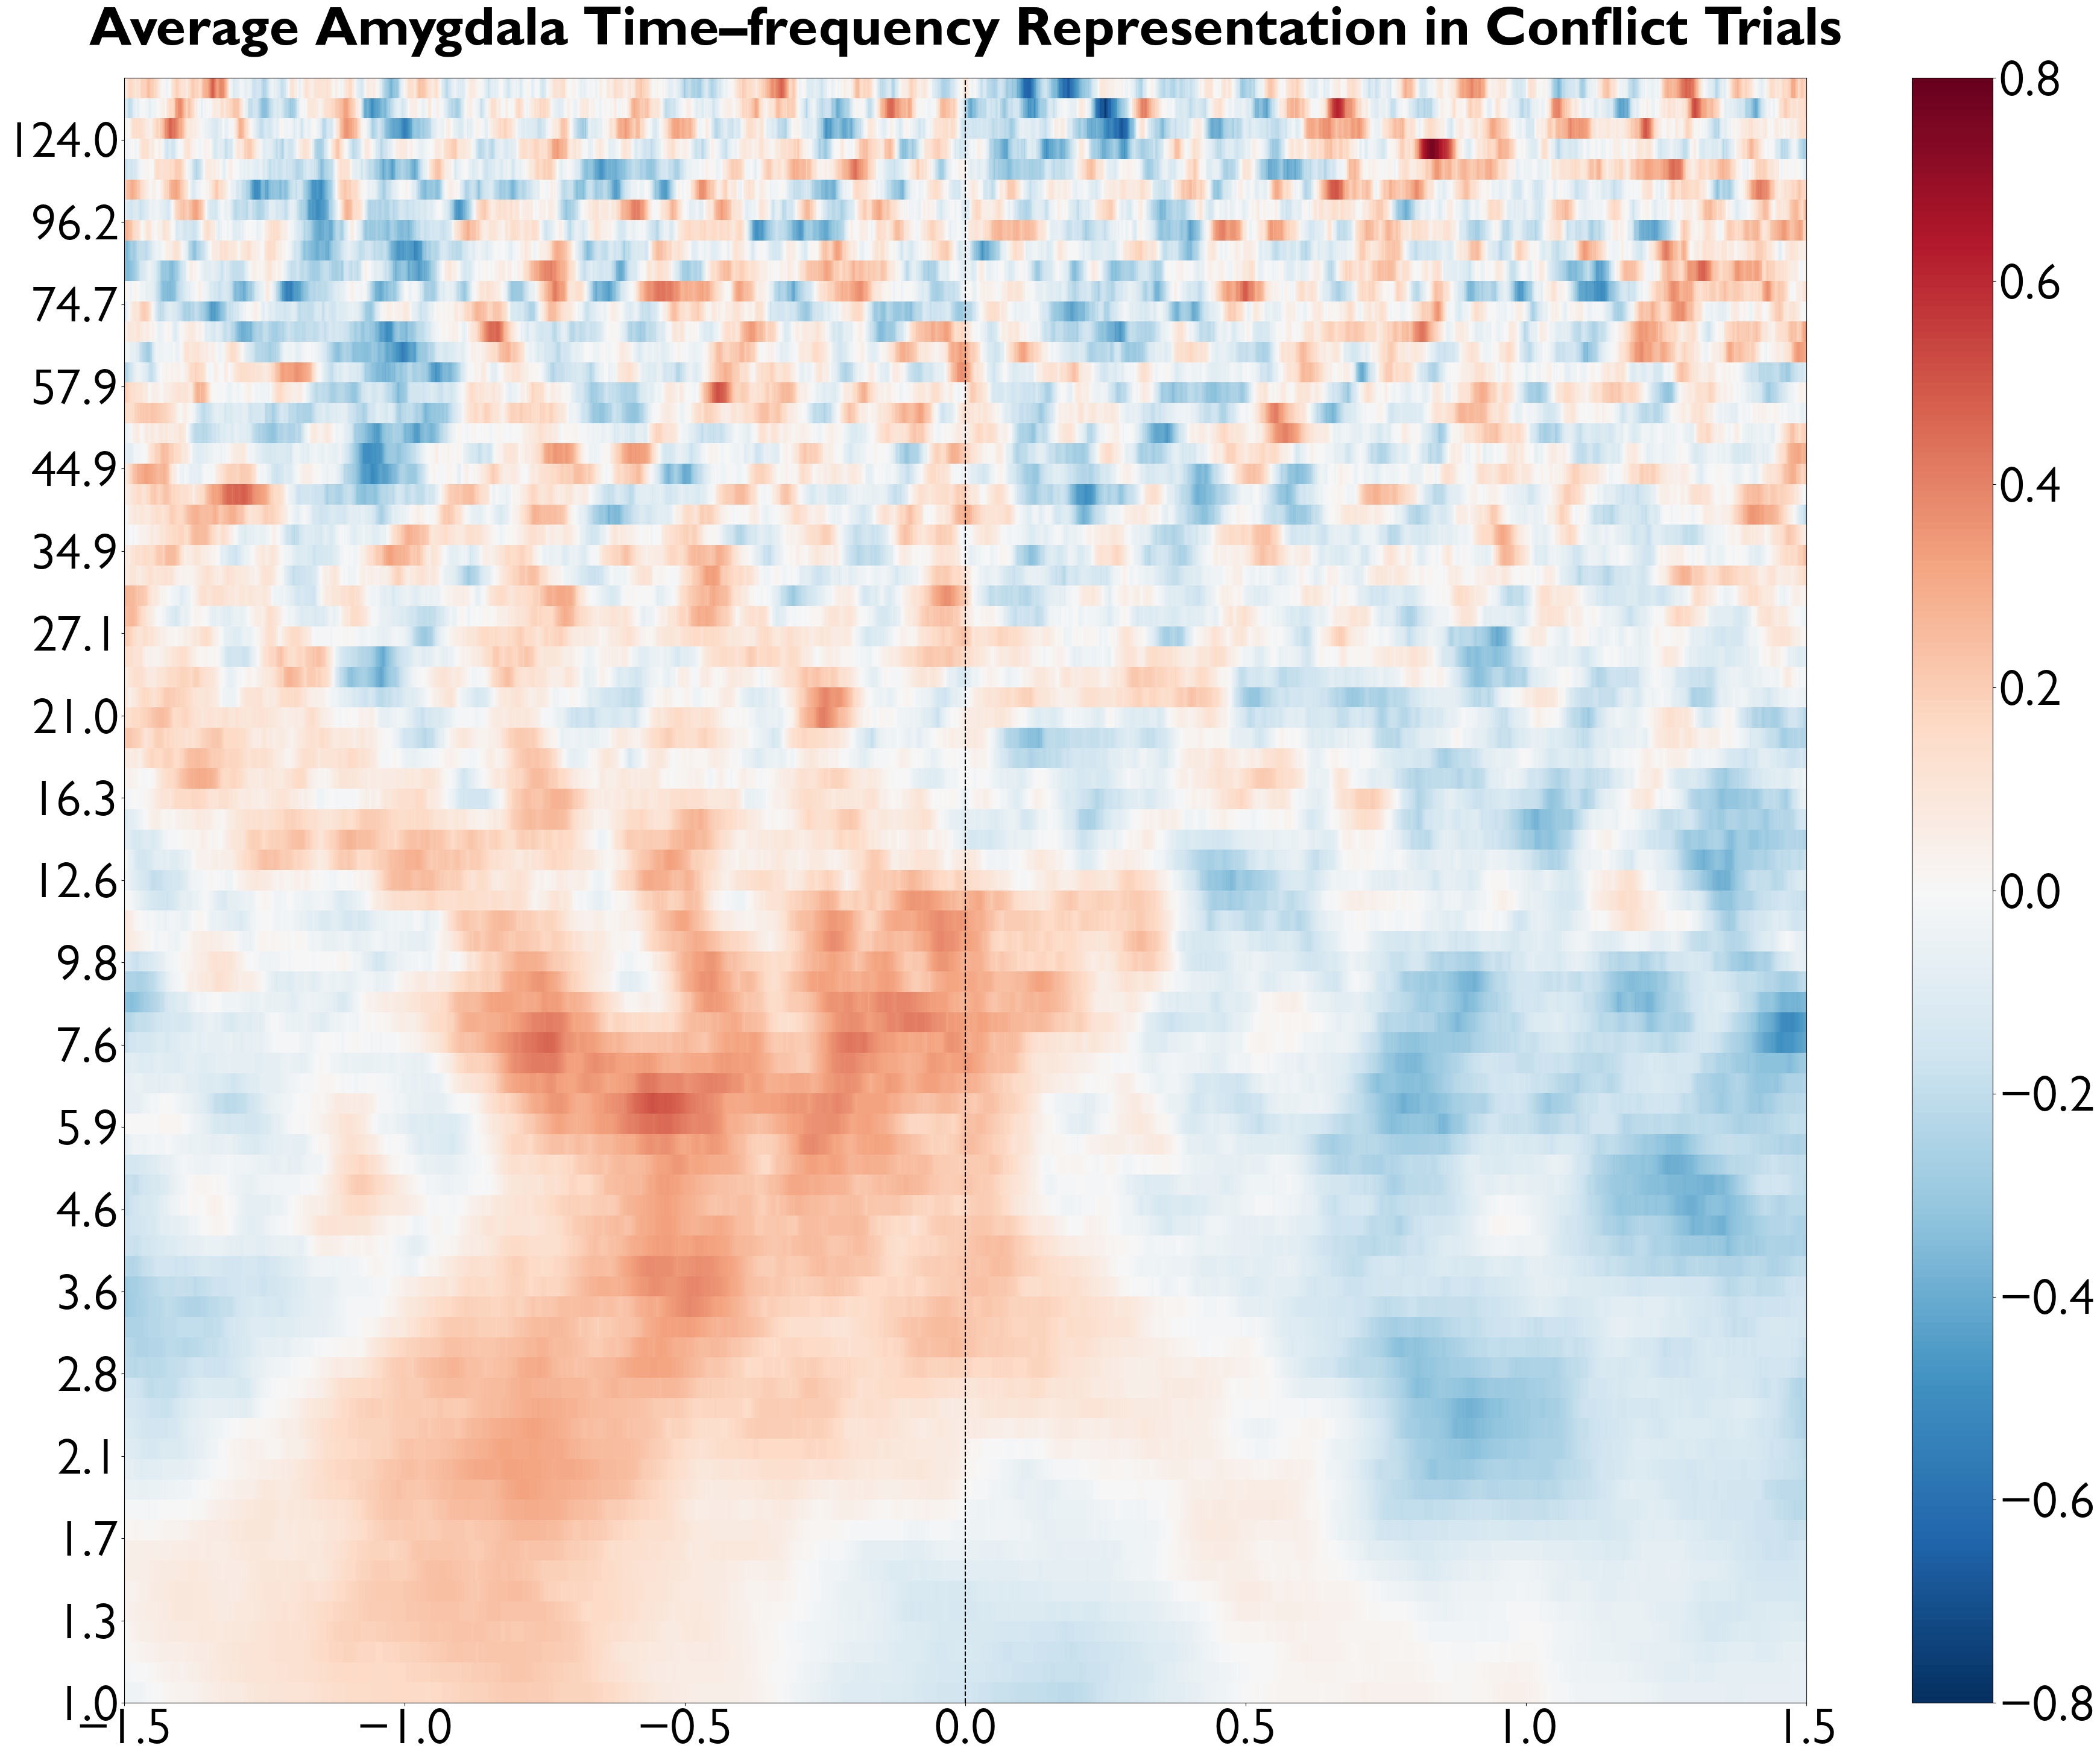

In [50]:
avg_tfr.plot_allsub_averages(all_subs_average_amyg_conflict, "Average Amygdala Time–frequency Representation in Conflict Trials", 'average_amyg_conflict_all_subs.png', -1.5, 1.5)

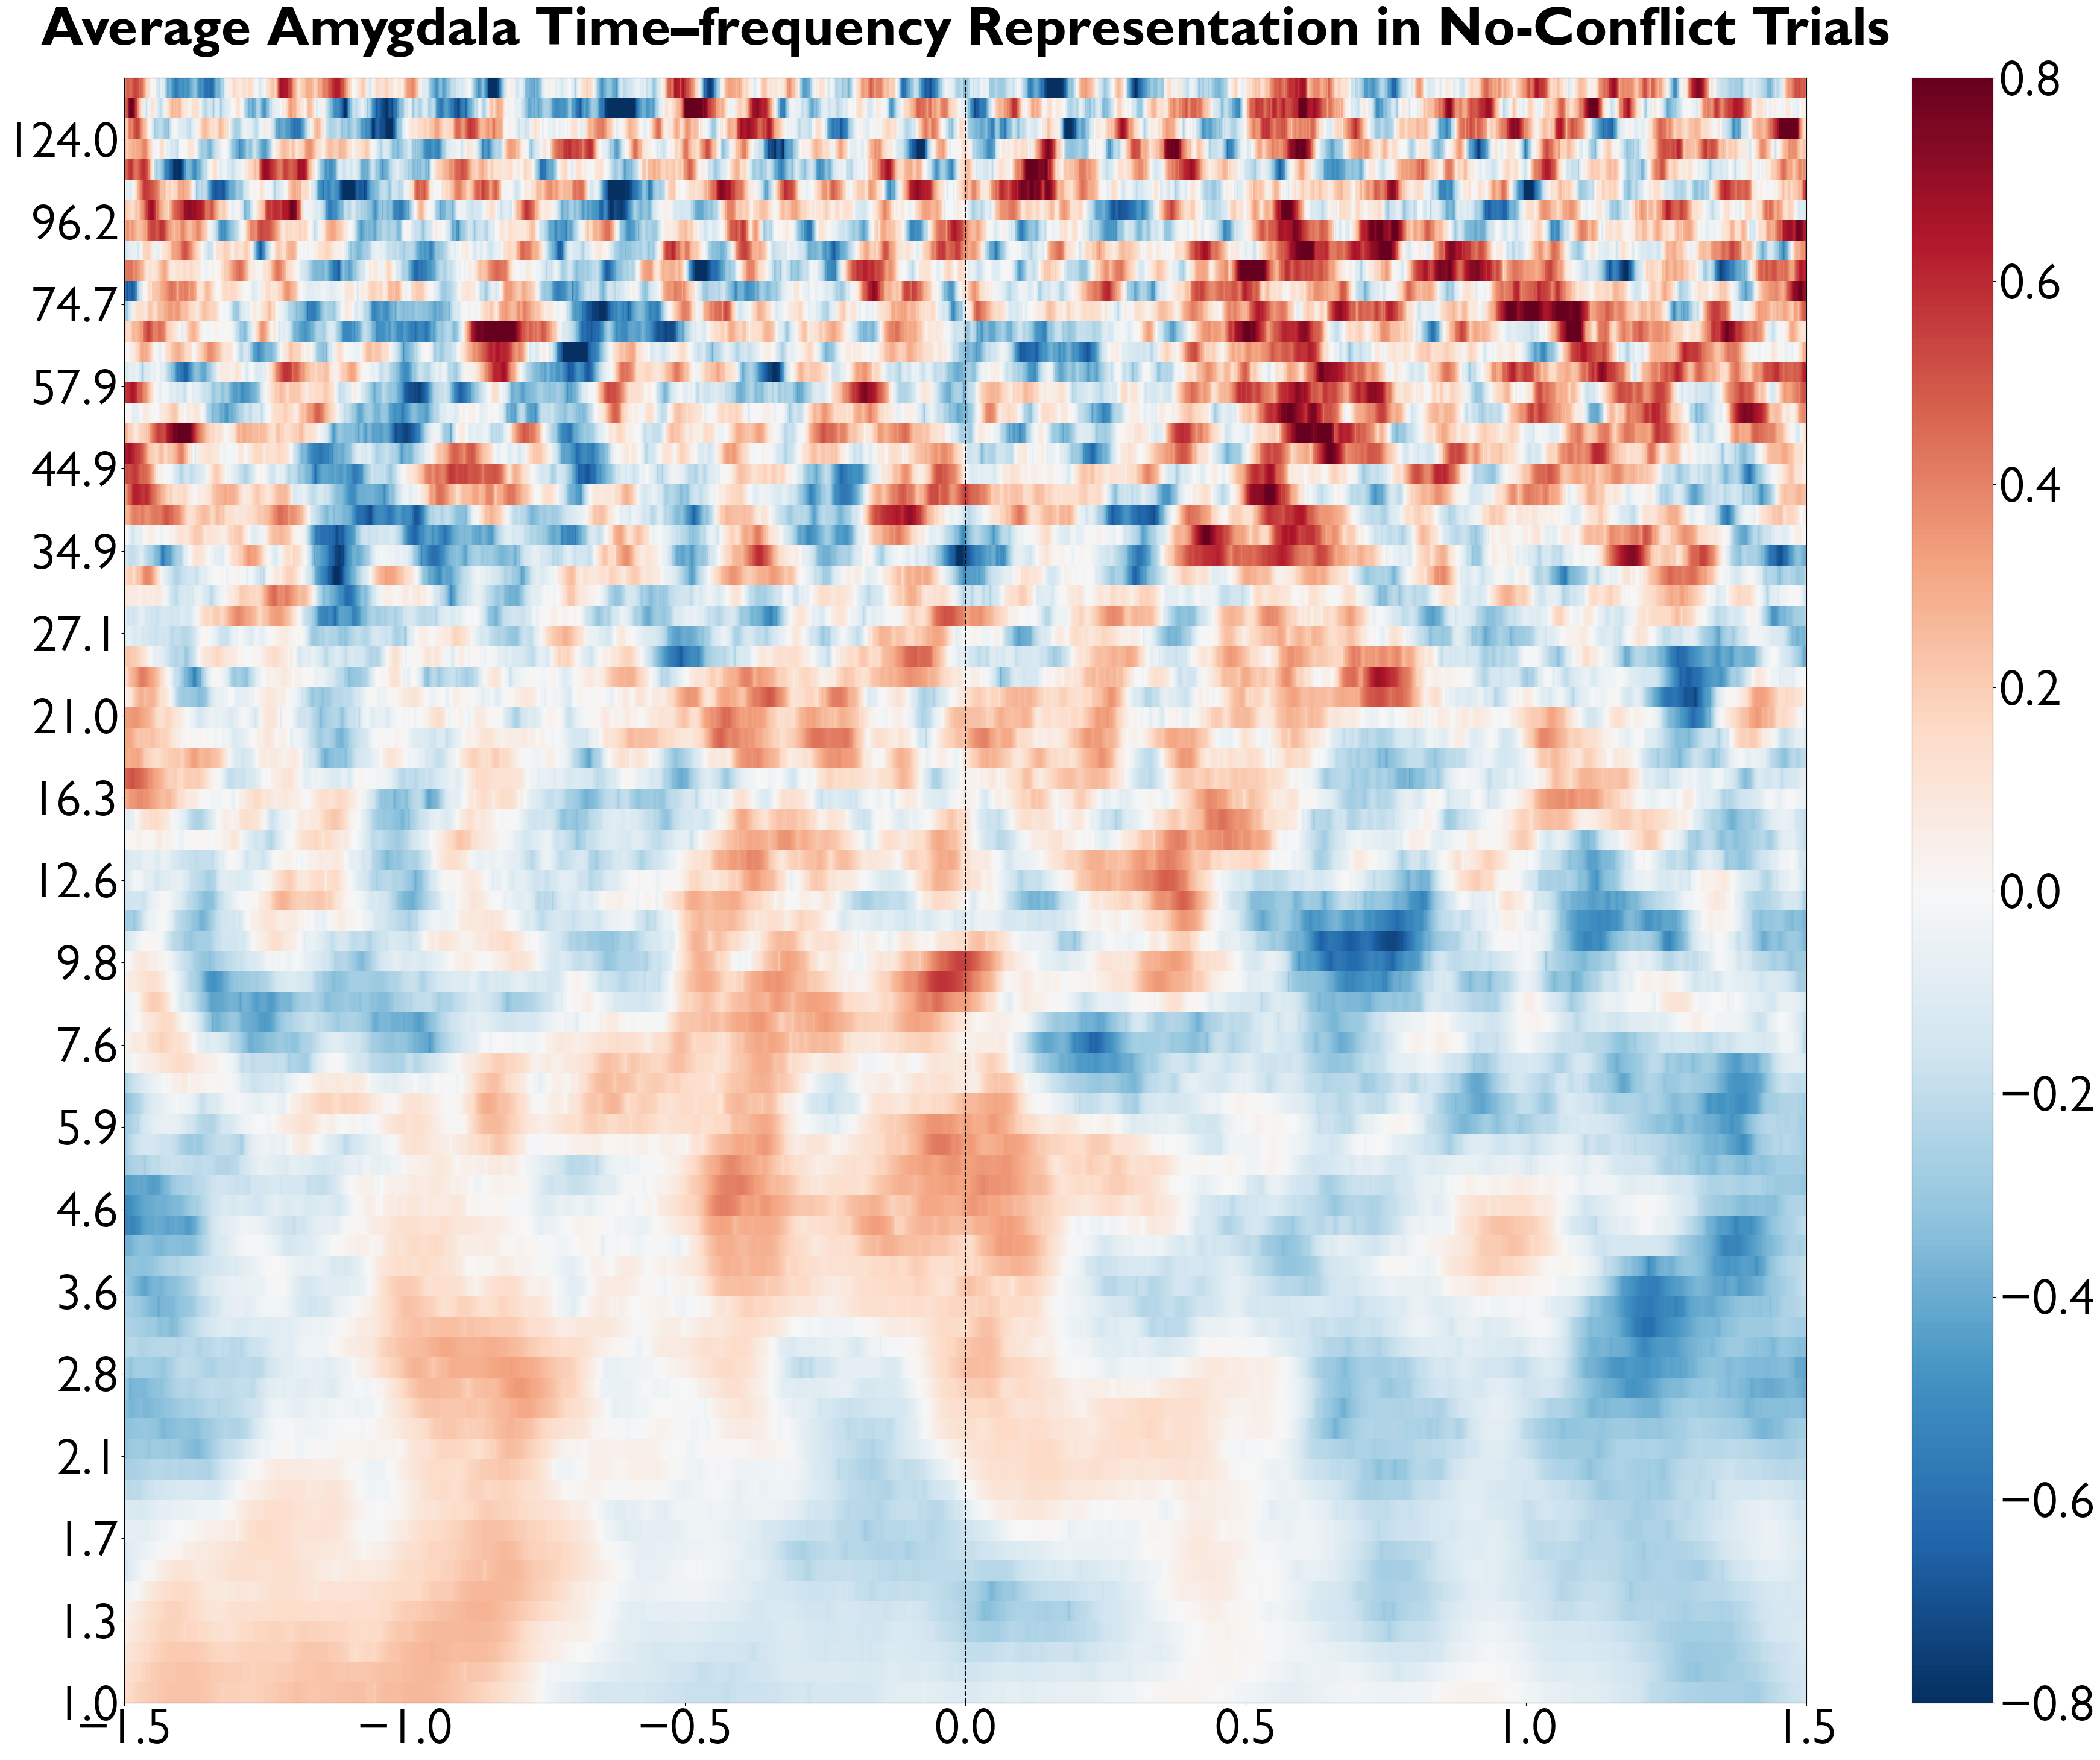

In [51]:
avg_tfr.plot_allsub_averages(all_subs_average_amyg_noconflict, "Average Amygdala Time–frequency Representation in No-Conflict Trials", 'average_amyg_noconflict_all_subs.png', -1.5, 1.5)

## Insula

In [52]:
# subjects
new_sub_list = ['BJH017', 'BJH046', 'BJH050', 'BJH051'] 
old_sub_list = ['BJH021', 'BJH025', 'BJH016', 'SLCH002', 'BJH026', 'BJH027', 'BJH029', 'BJH041', 'LL12']


all_subs_average_insulas = calculate_last_away_new_sub_average(new_sub_list, old_sub_list, 'insula')

# separate averages #
all_subs_average_insula_conflict = all_subs_average_insulas[0]
all_subs_average_insula_noconflict = all_subs_average_insulas[1]


Reading /home/brooke/pacman/preprocessing/BJH017/ieeg/last_away/ghost-insula-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH017/ieeg/last_away/noghost-insula-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/ghost-insula-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/noghost-insula-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/ghost-insula-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/noghost-insula-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/ghost-insula-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/noghost-insula-tfr.h5 ...


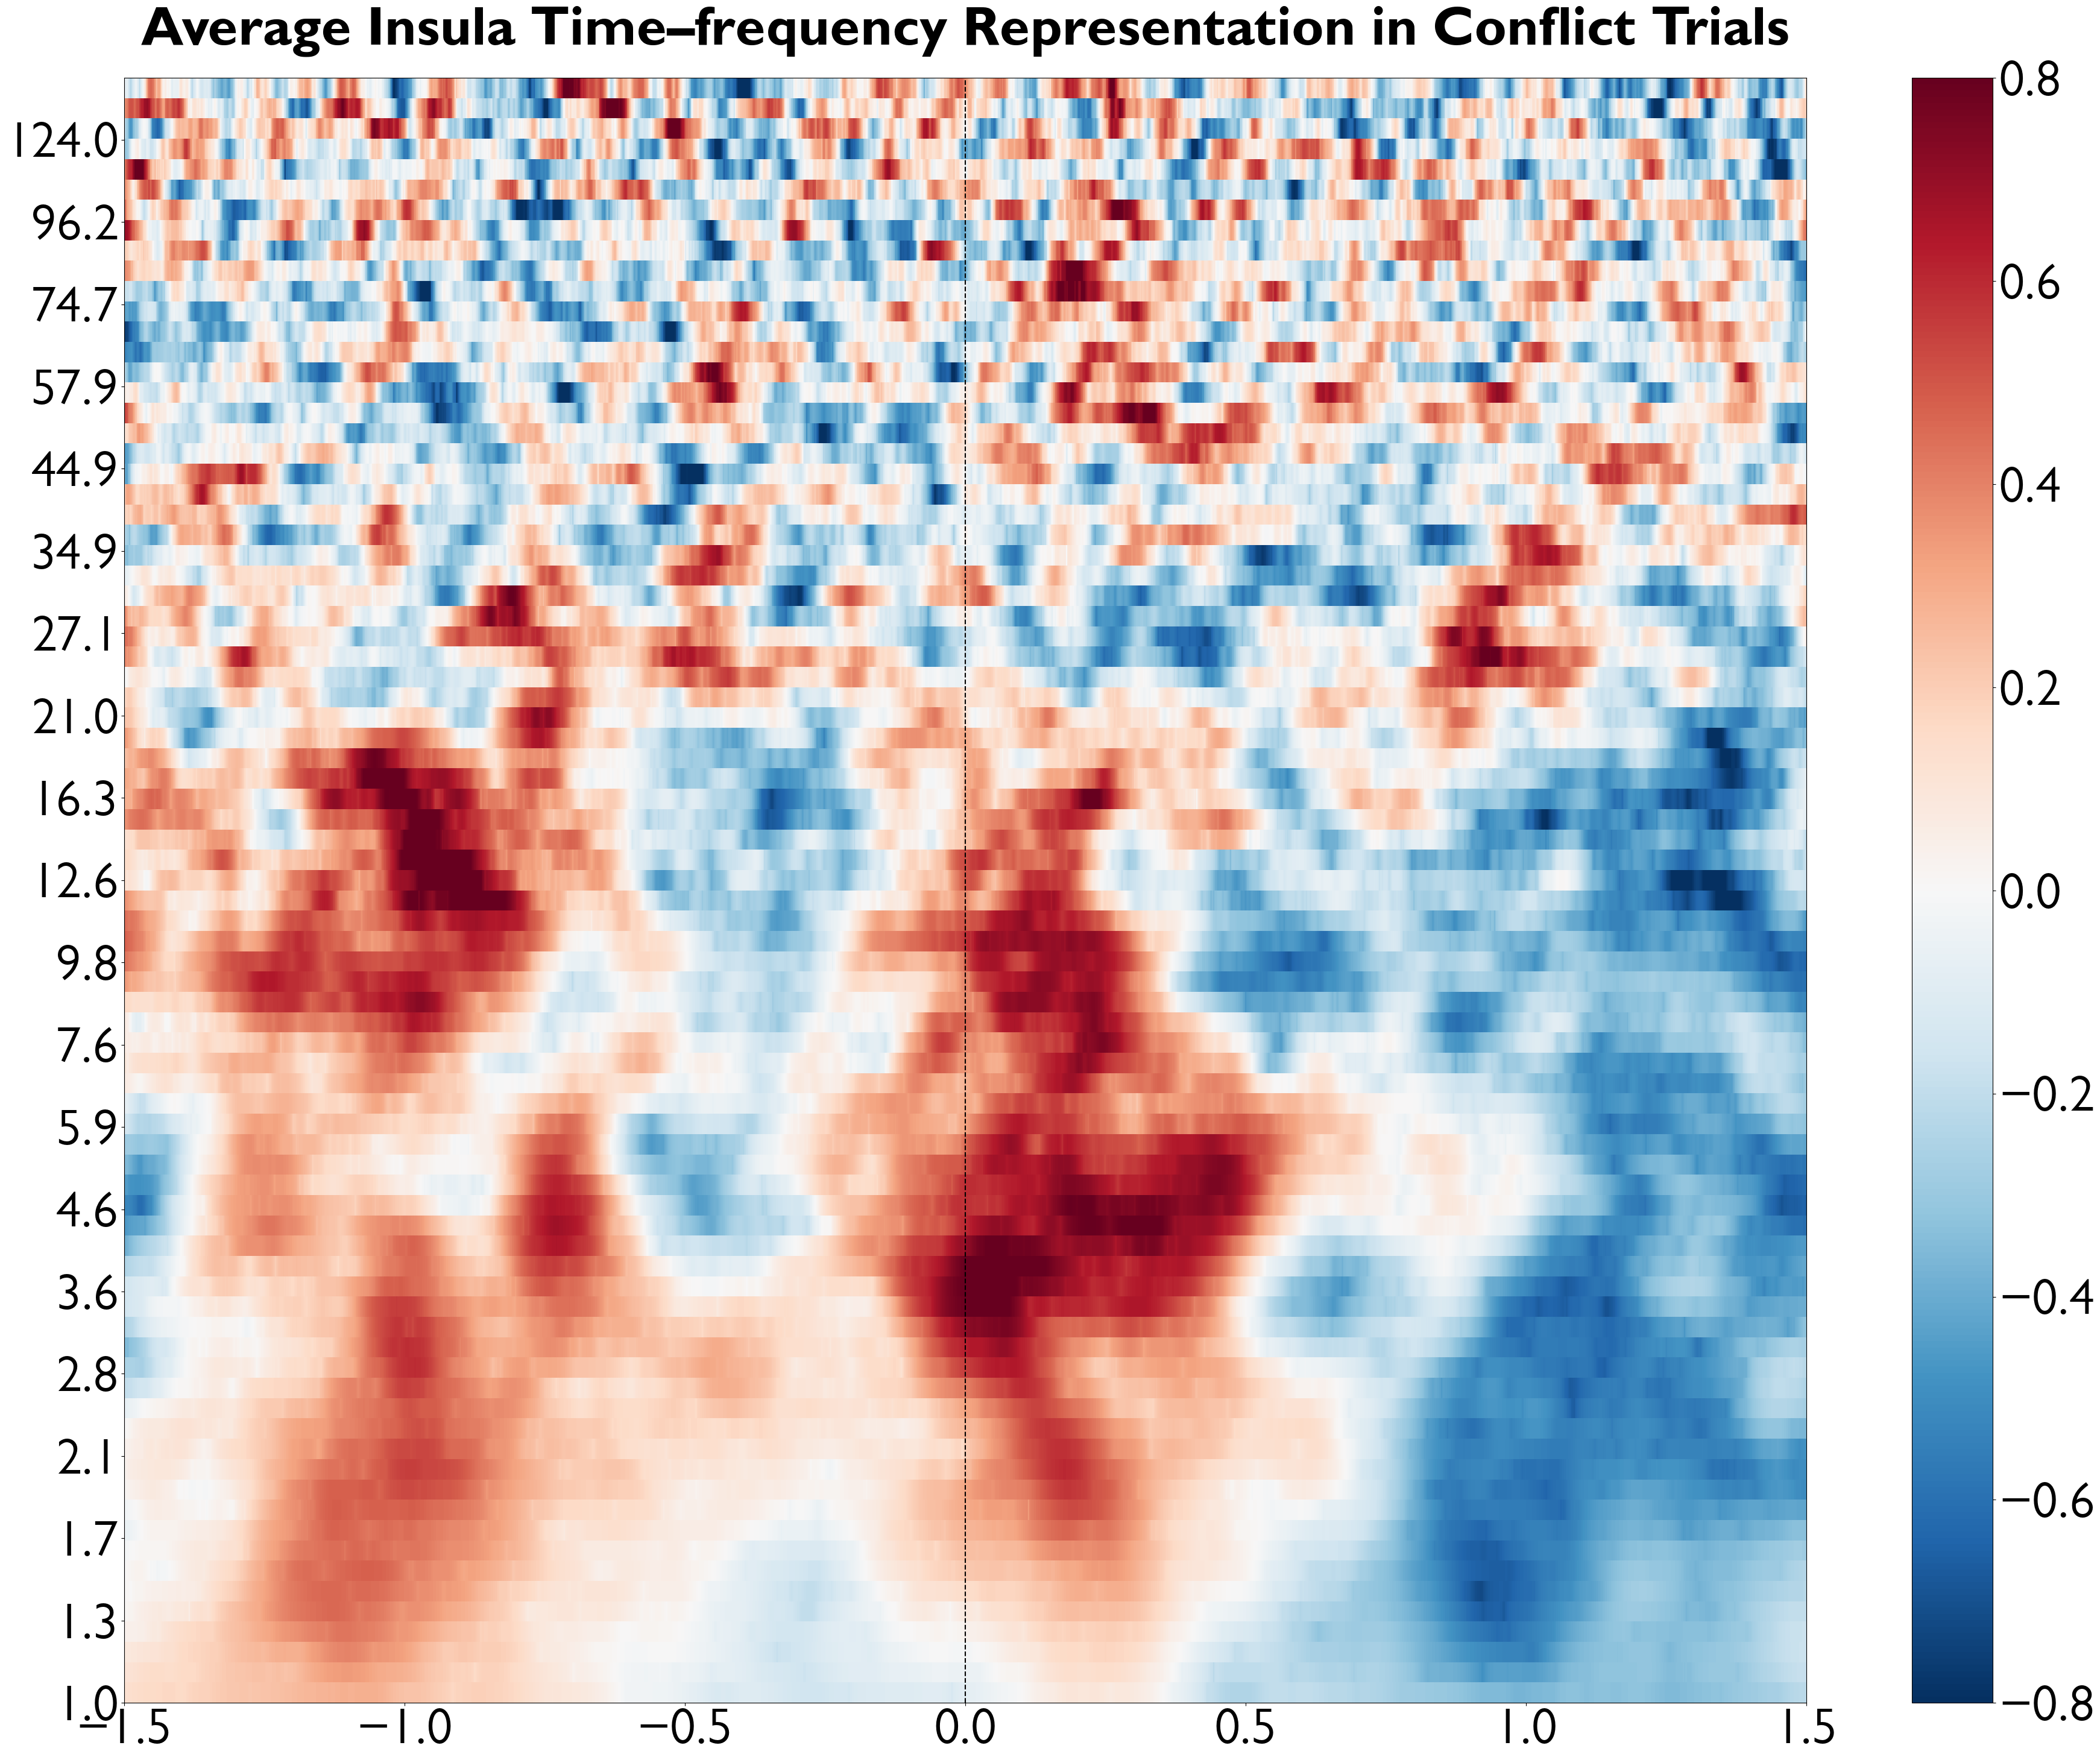

In [53]:
avg_tfr.plot_allsub_averages(all_subs_average_insula_conflict, "Average Insula Time–frequency Representation in Conflict Trials", 'average_insula_conflict_all_subs.png', -1.5, 1.5)

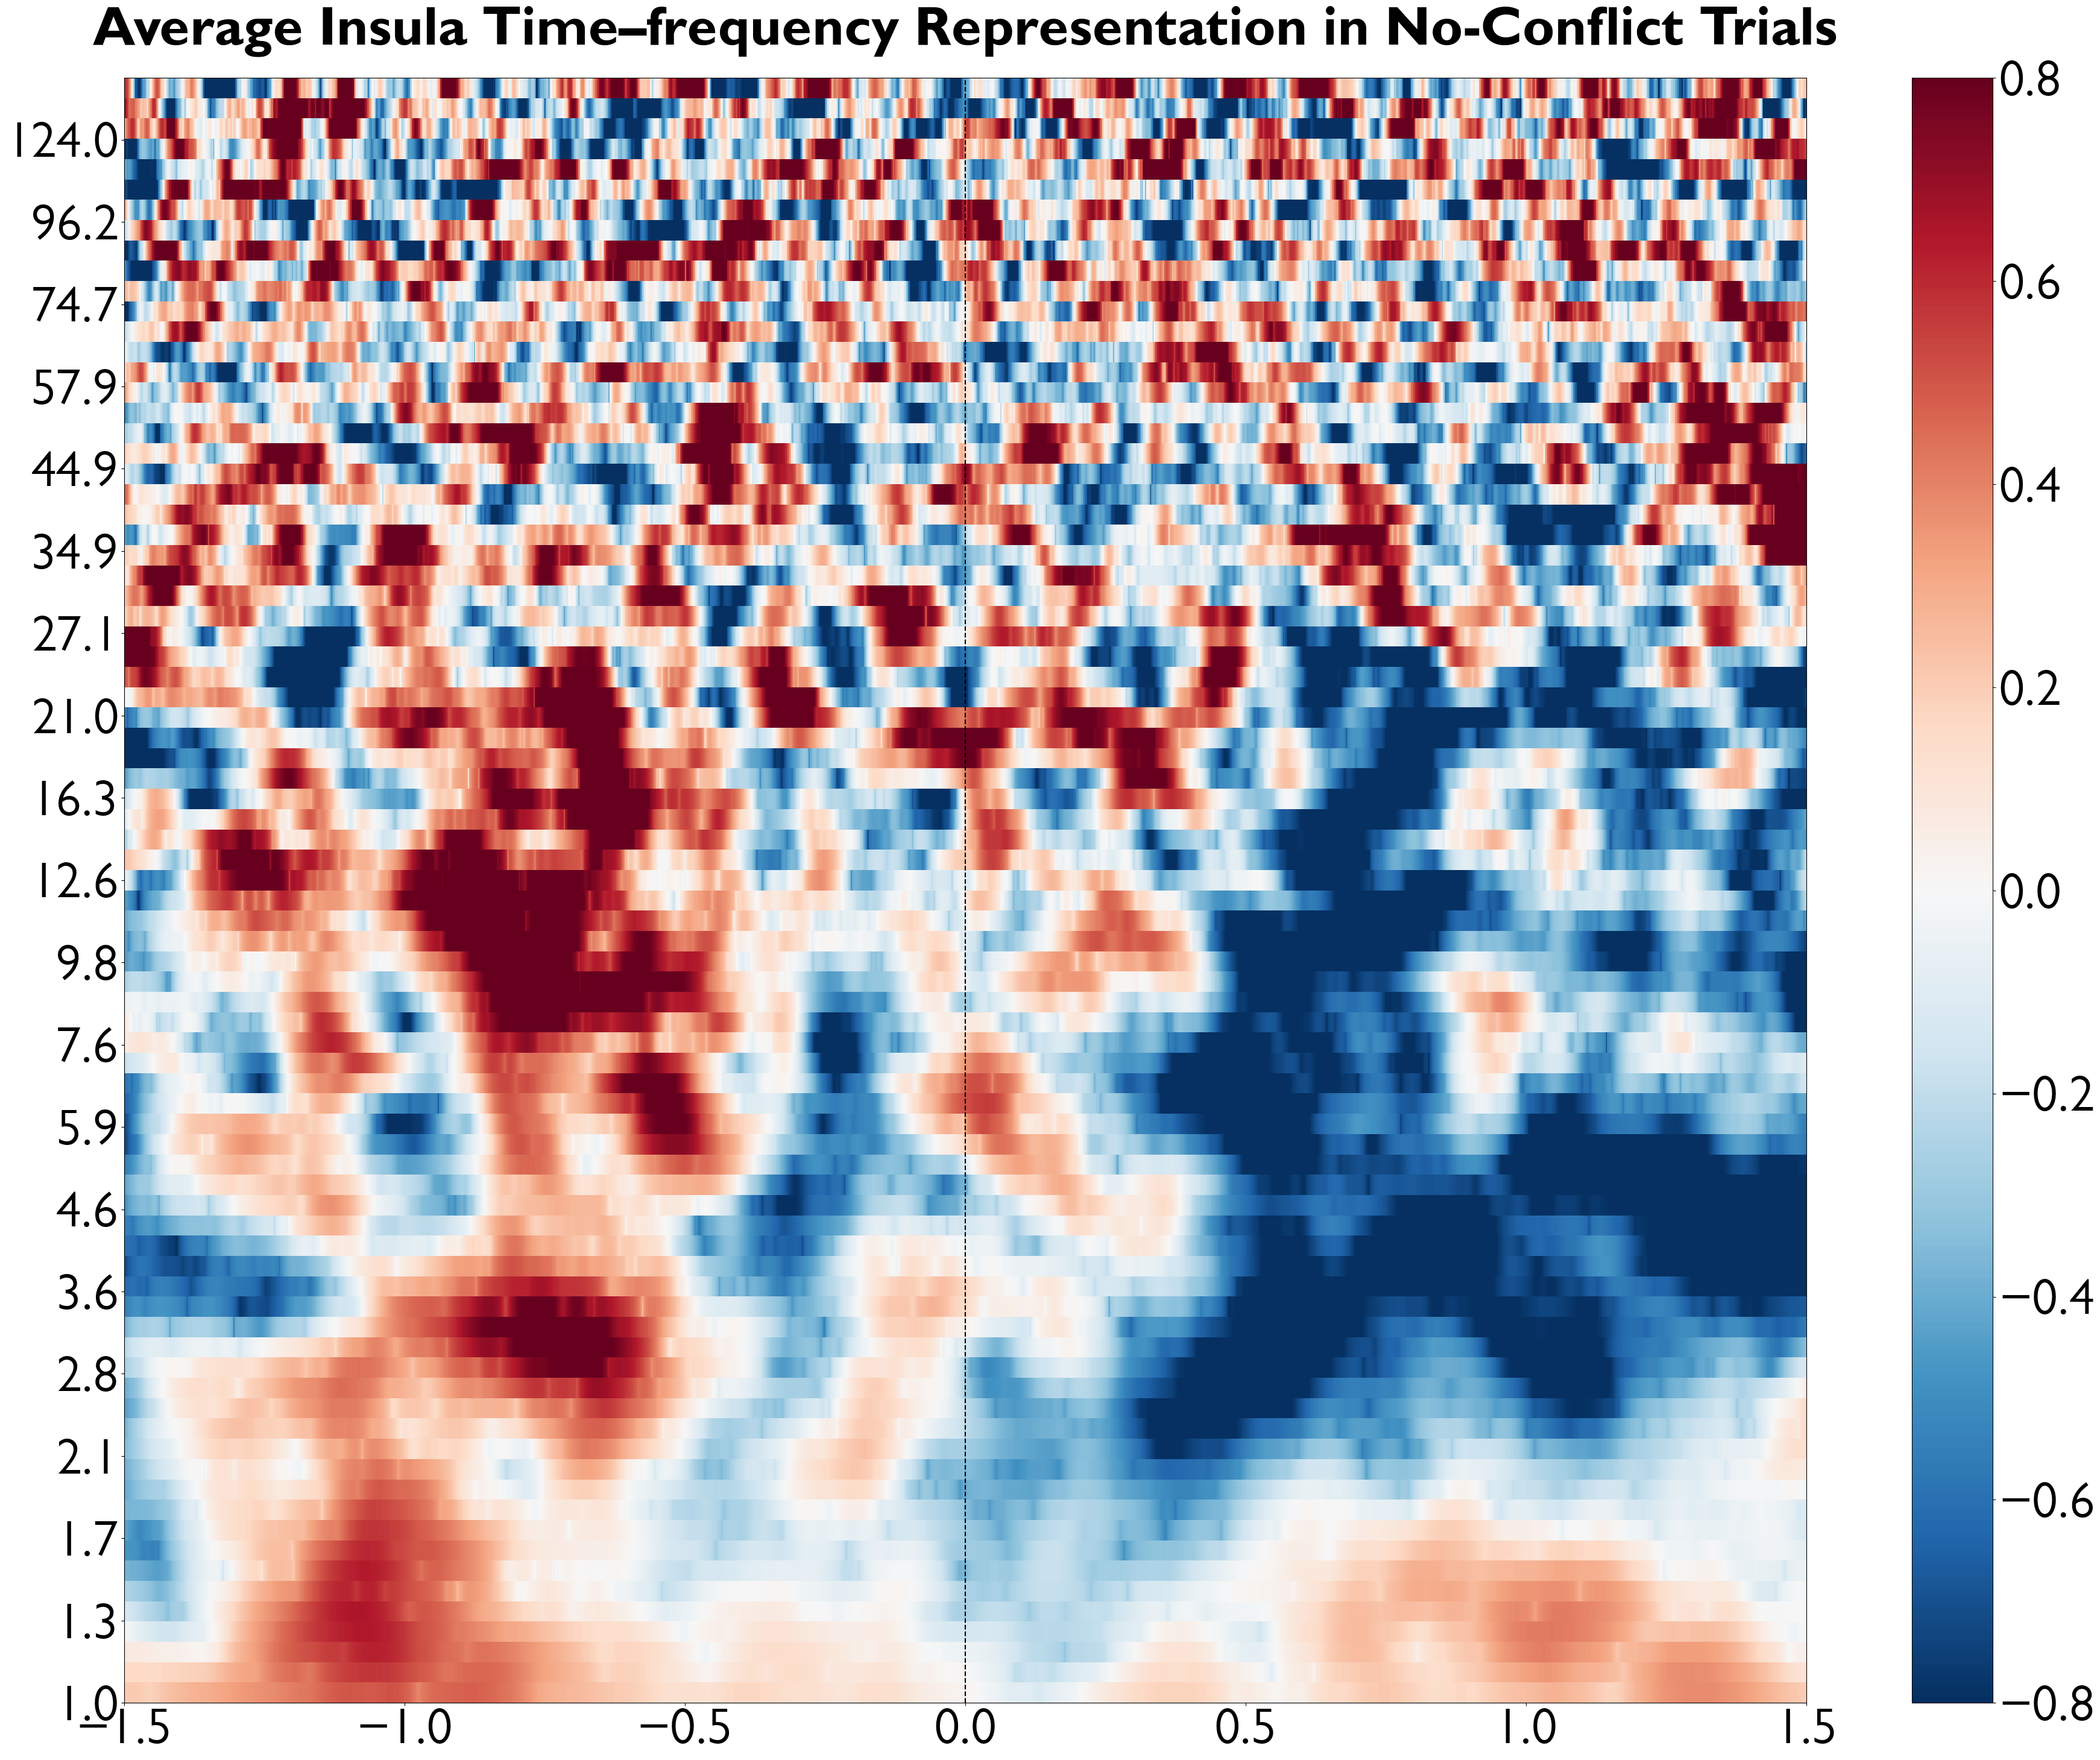

In [54]:
avg_tfr.plot_allsub_averages(all_subs_average_insula_noconflict, "Average Insula Time–frequency Representation in No-Conflict Trials", 'average_insula_noconflict_all_subs.png', -1.5, 1.5)

## MFG

In [55]:
new_sub_list = ['BJH046', 'BJH050', 'BJH051']
old_sub_list = ['BJH021', 'BJH025', 'BJH016', 'SLCH002', 'BJH026', 'BJH027', 'BJH039', 'LL10', 'LL12', 'LL13', 'LL14', 'LL17', 'LL19']

# average subjects together 
all_subs_average_mfgs = calculate_last_away_new_sub_average(new_sub_list, old_sub_list, 'dlpfc', ROIs, 'mfg')

# separate averages #
all_subs_average_mfg_conflict = all_subs_average_mfgs[0]
all_subs_average_mfg_noconflict = all_subs_average_mfgs[1]


Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/ghost-dlpfc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH046/ieeg/last_away/noghost-dlpfc-tfr.h5 ...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/ghost-dlpfc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH050/ieeg/last_away/noghost-dlpfc-tfr.h5 ...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/ghost-dlpfc-tfr.h5 ...
Reading /home/brooke/pacman/preprocessing/BJH051/ieeg/last_away/noghost-dlpfc-tfr.h5 ...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pic

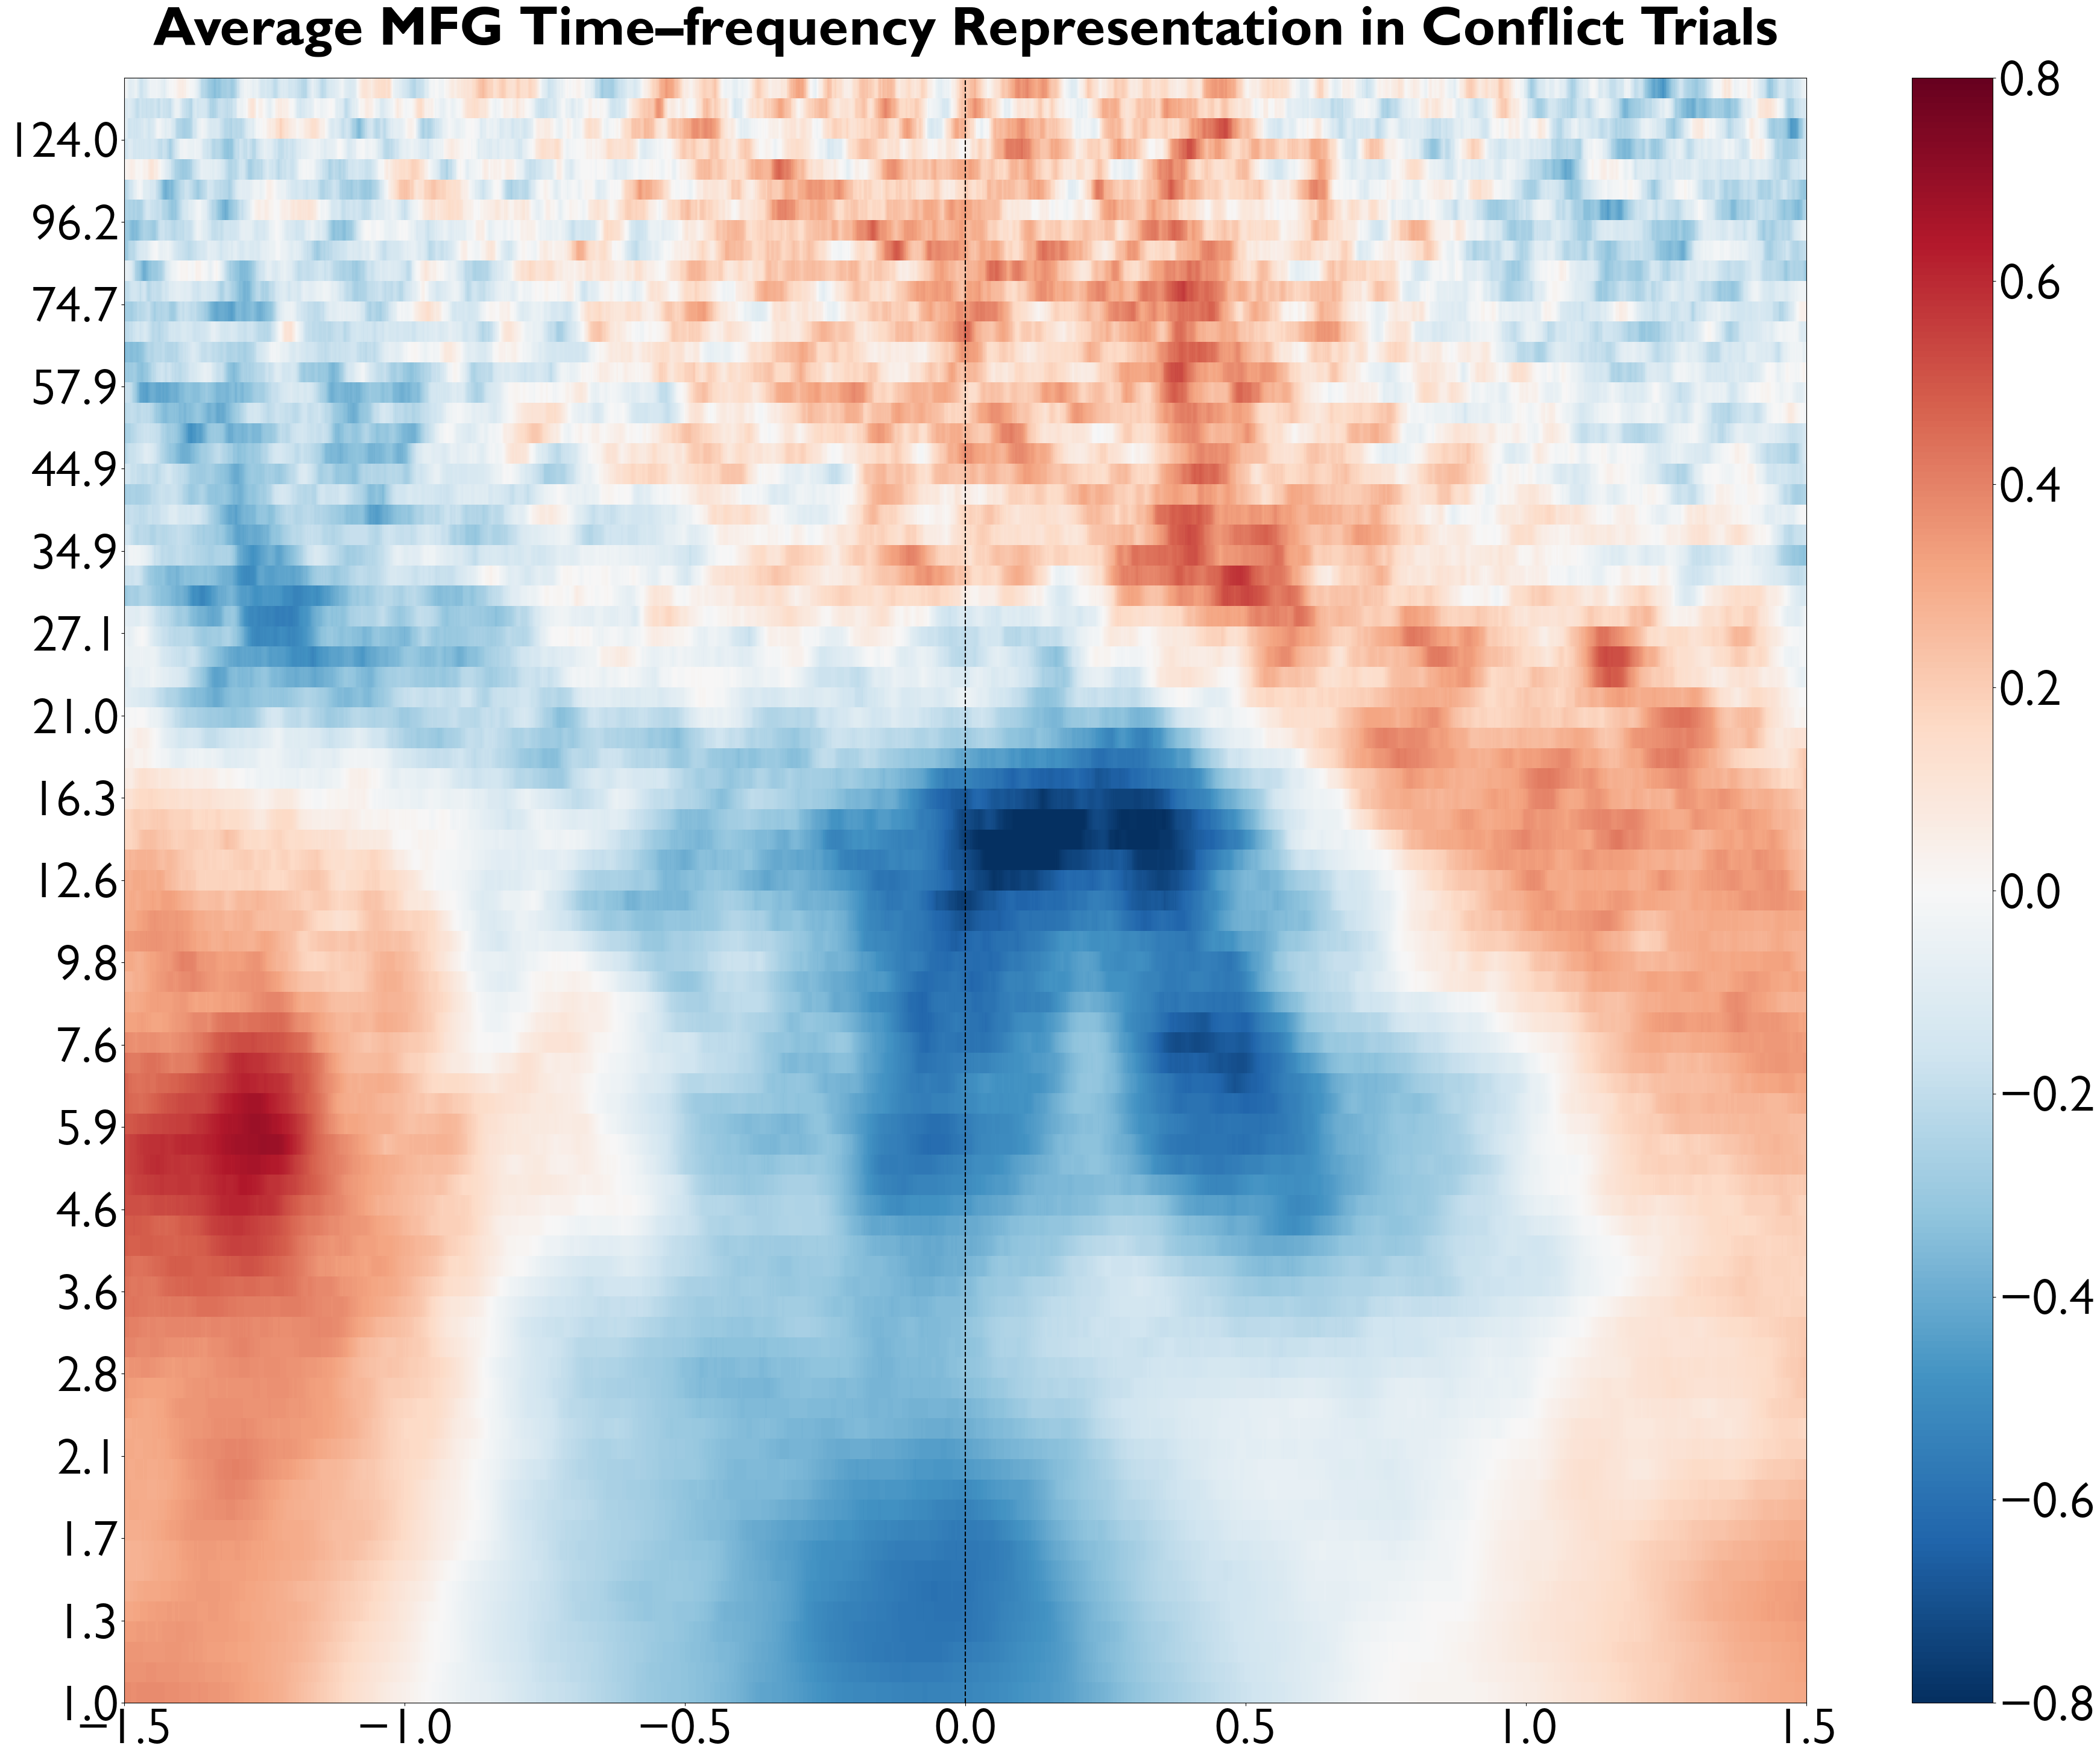

In [56]:
avg_tfr.plot_allsub_averages(all_subs_average_mfg_conflict, "Average MFG Time–frequency Representation in Conflict Trials", 'average_mfg_conflict_all_subs.png', -1.5, 1.5)

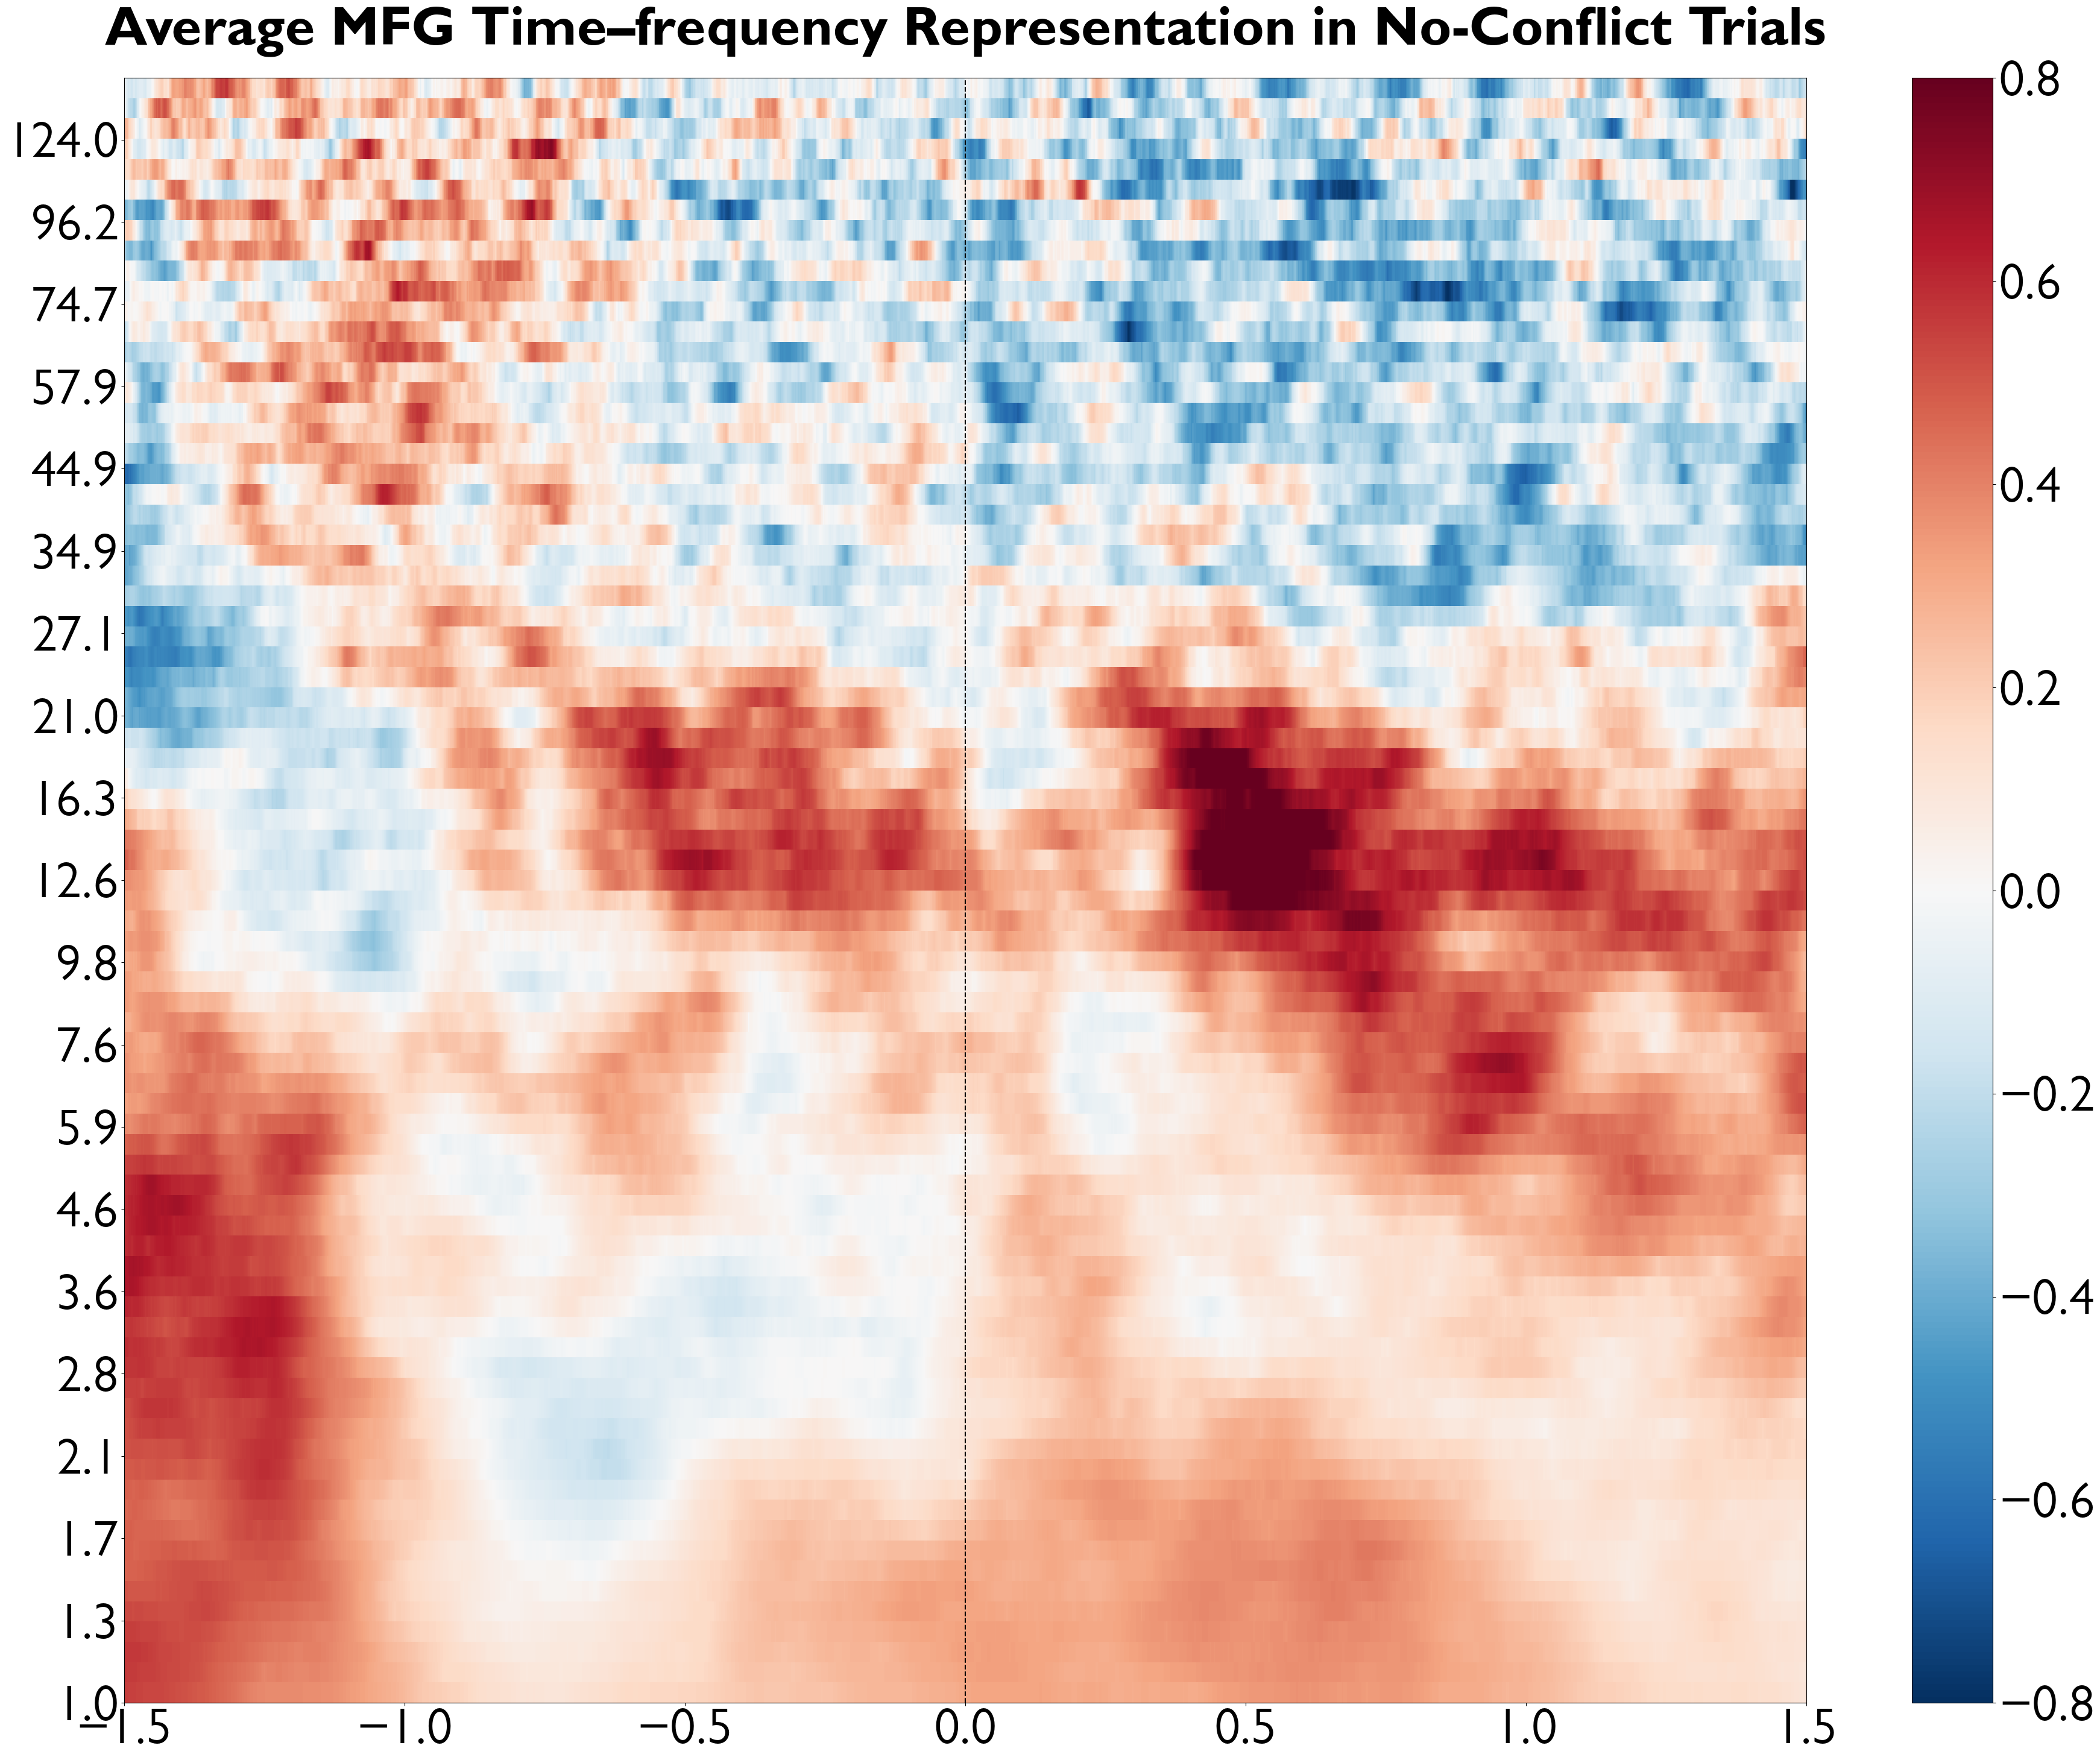

In [57]:
avg_tfr.plot_allsub_averages(all_subs_average_mfg_noconflict, "Average MFG Time–frequency Representation in No-Conflict Trials", 'average_mfg_noconflict_all_subs.png', -1.5, 1.5)